In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [60]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931467,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_fmm": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_sigmoid": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_fmm_sigmoid": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_lmm": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechw_fmm_lmm": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [4]:
trackers = {}
rets ={}

In [5]:
def vis_imp(ret):
    x = list(range(len(ret['client_imp_history'])))
    client_ids = list(ret['client_imp_history'][0][2]['metrics'].keys())

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for client_id in client_ids:
        for idx, metric in enumerate(['imp@rmse', 'imp@w2', 'imp@sliced_ws']):
            y = [ret['client_imp_history'][i][2]['metrics'][client_id][metric] for i in x]
            ax[idx].plot(x, y, label=client_id)
            ax[idx].set_title(metric)
            if metric == 'imp@rmse':
                ax[idx].set_ylim([0, 0.2])
                ax[idx].set_xticks(x)
                ax[idx].legend()
            
    plt.show()

## MNAR LR 0.3 0.3

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 09:22:02.380 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 69.52312539995182


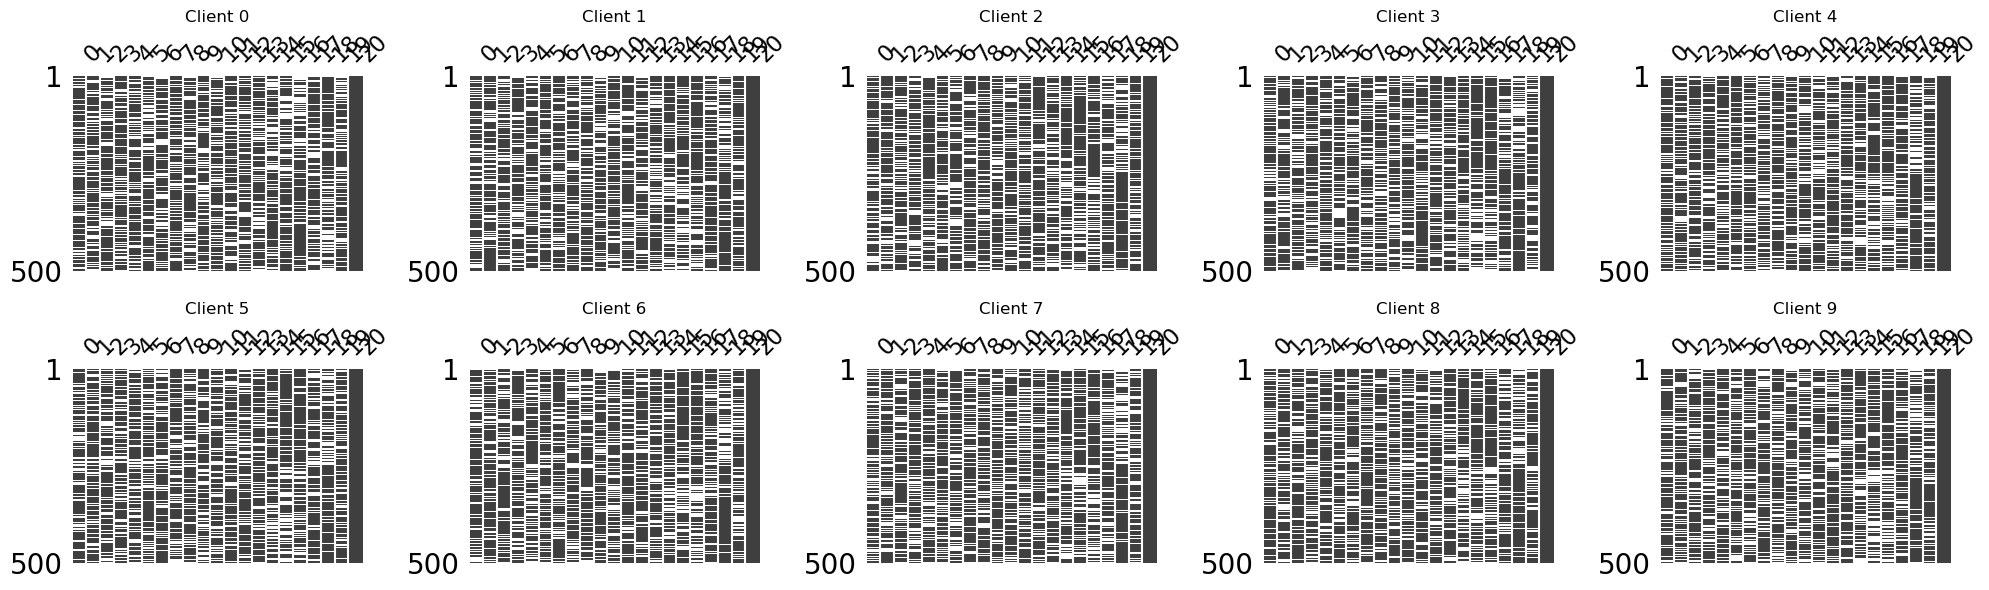

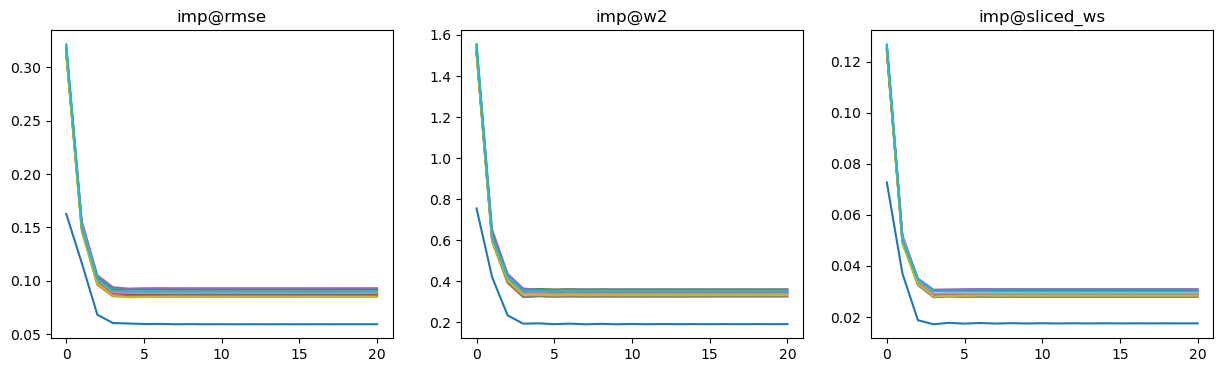

{'imp@rmse': 0.08528148320408344, 'imp@ws': 0.3263976129173962, 'imp@sliced_ws': 0.027991950515391426}


In [53]:
name = 'mnar_lr0.3_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.1'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 09:46:39.257 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:46:39.258 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 09:47:14.646 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:47:14.647 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 09:47:49.072 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:47:49.073 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 09:47:52.492 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 74.14200650004204


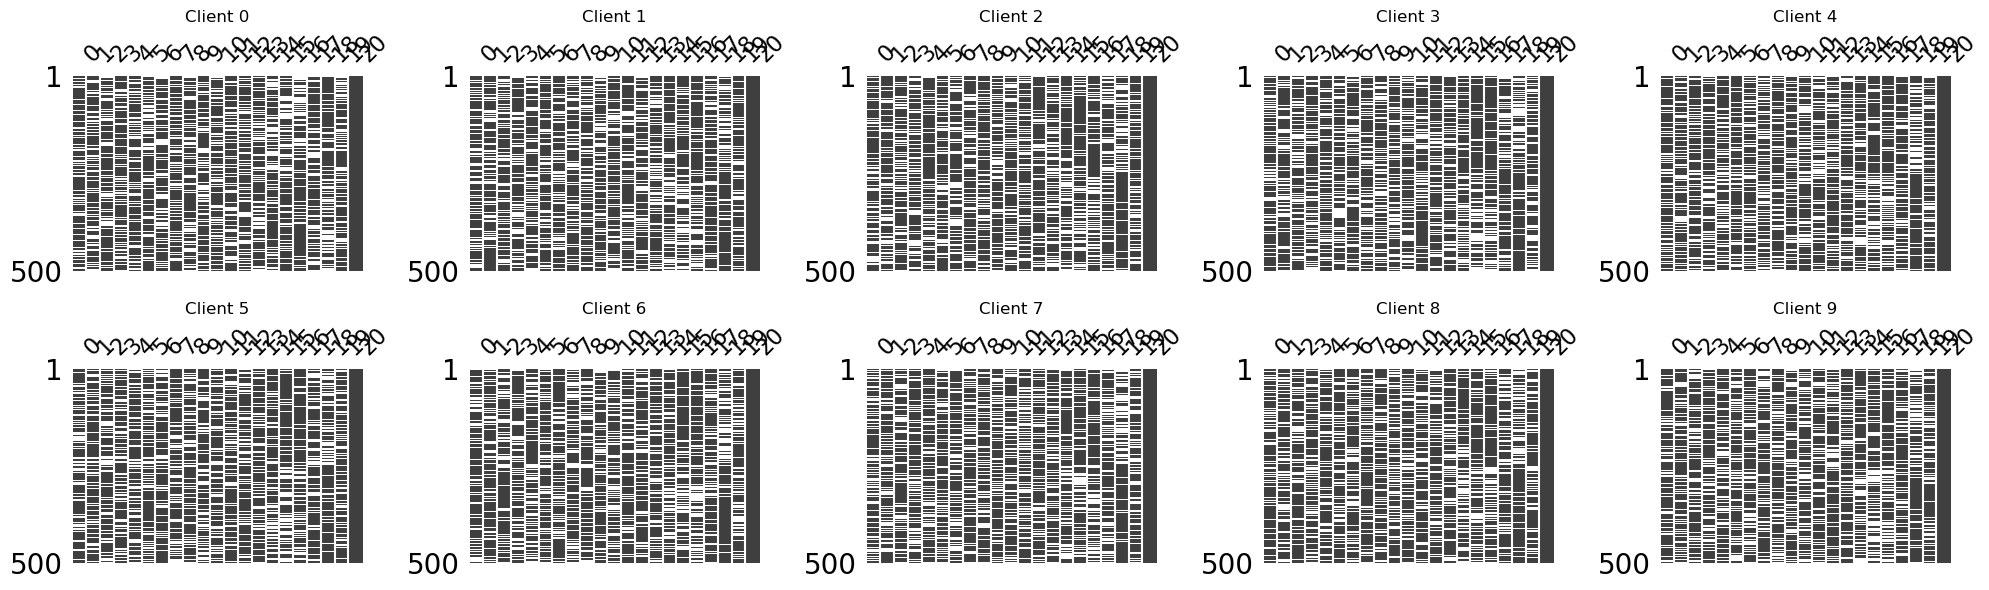

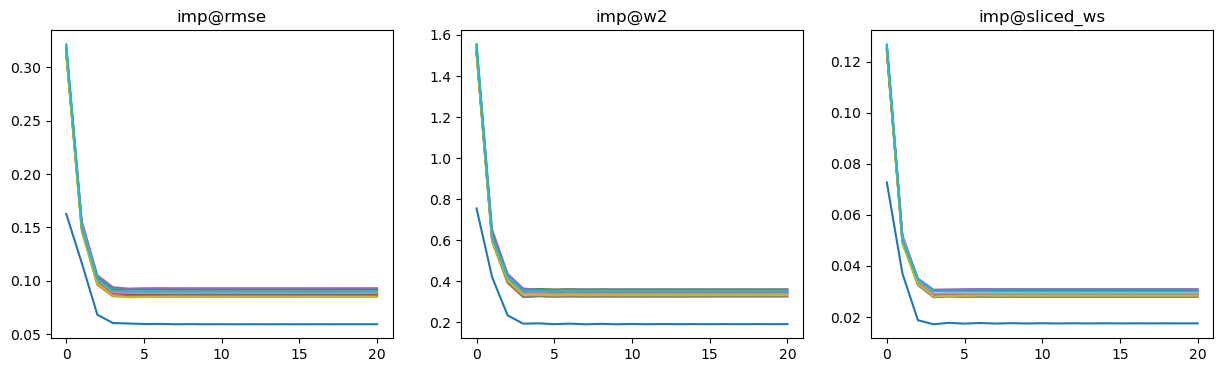

{'imp@rmse': 0.08528148313904993, 'imp@ws': 0.32639761266293926, 'imp@sliced_ws': 0.027991950501038726}


In [61]:
name = 'mnar_lr0.3_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.1'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['imputation']['clip'] = True
config2['agg_strategy_imp']['strategy'] = 'fedmechw_fmm'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR LR 0.3 0.6

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:31:32.691 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 60.90247079997789


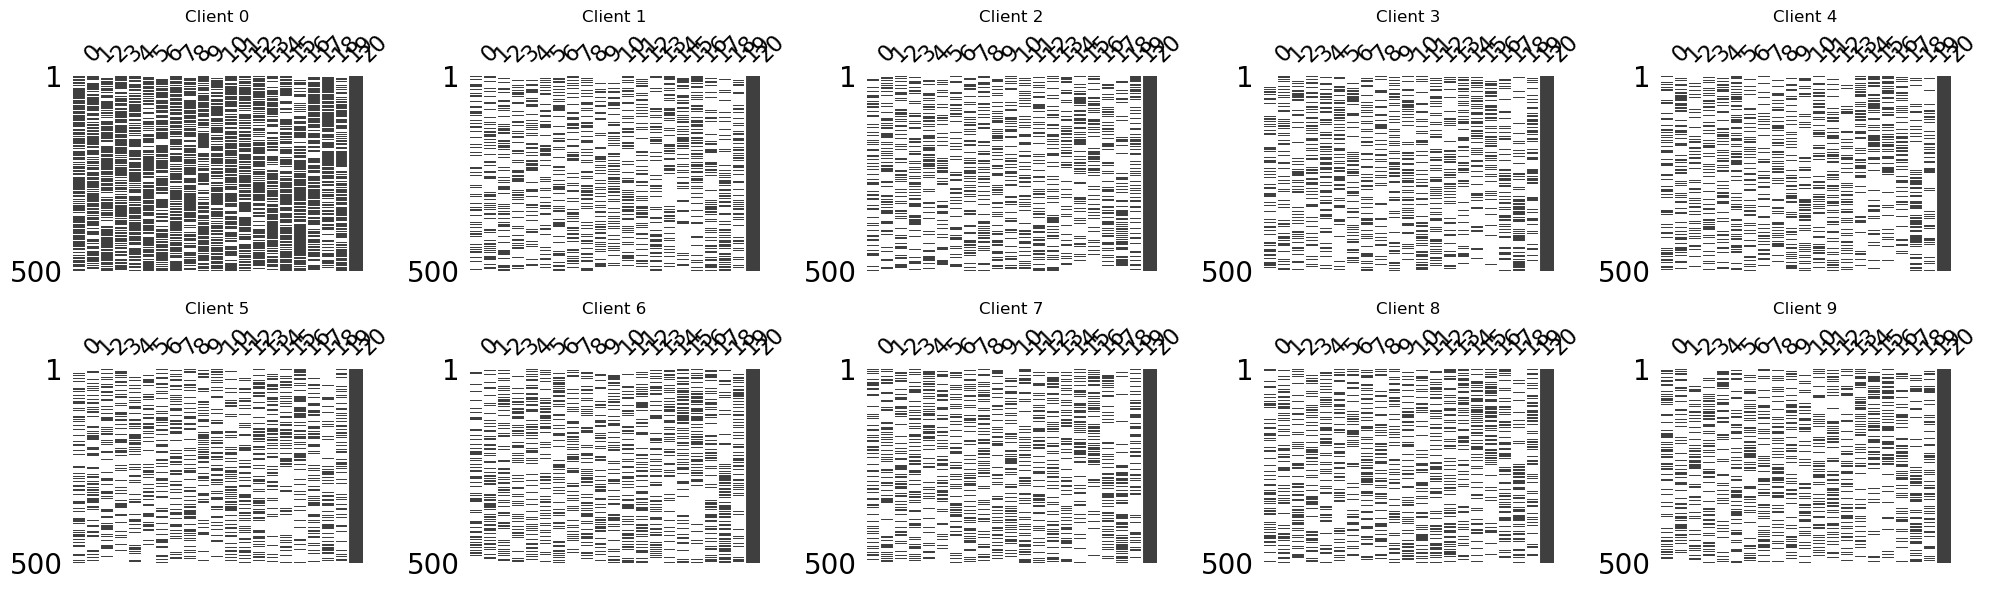

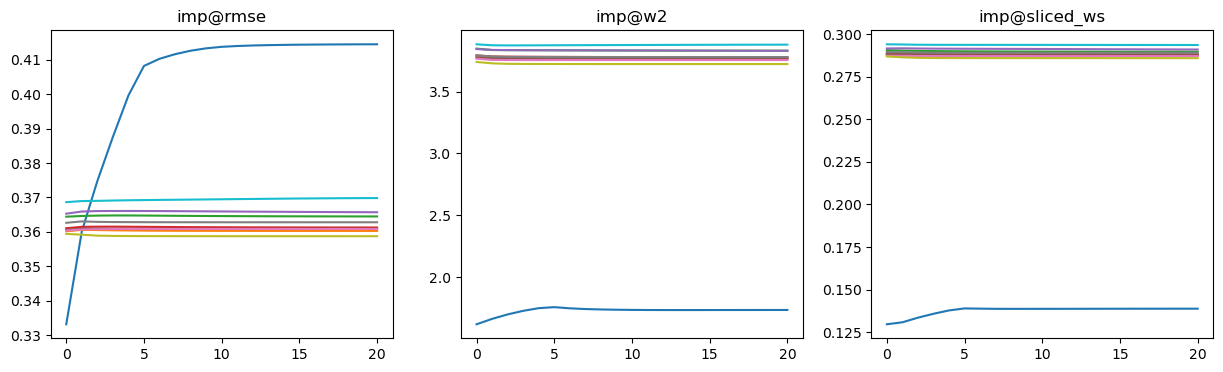

{'imp@rmse': 0.36793902753761143, 'imp@ws': 3.5835718988372, 'imp@sliced_ws': 0.2738203653411215}


In [37]:
name = 'mnar_lr0.3_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.1'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:32:53.978 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 66.05719540000428


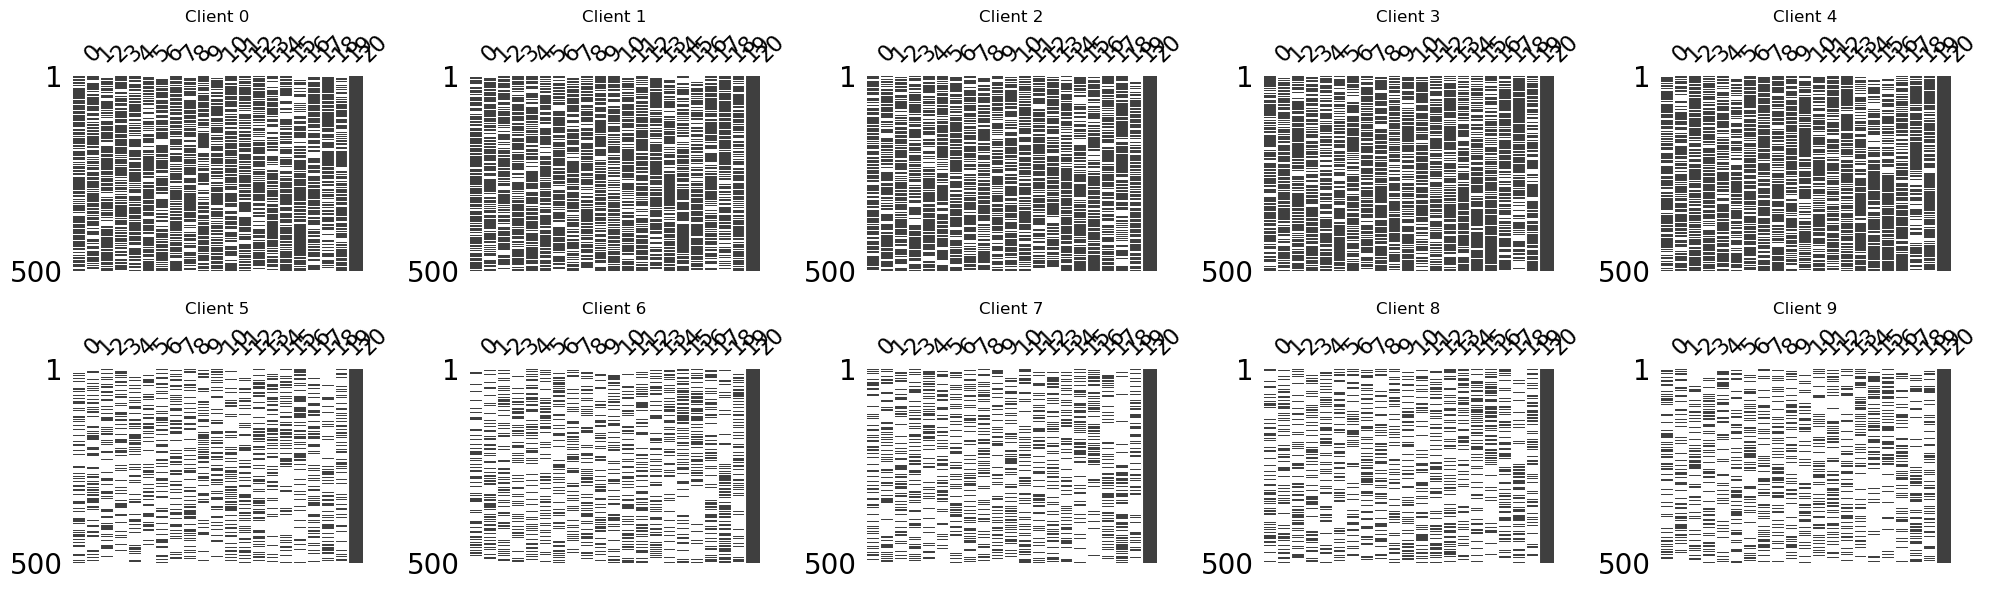

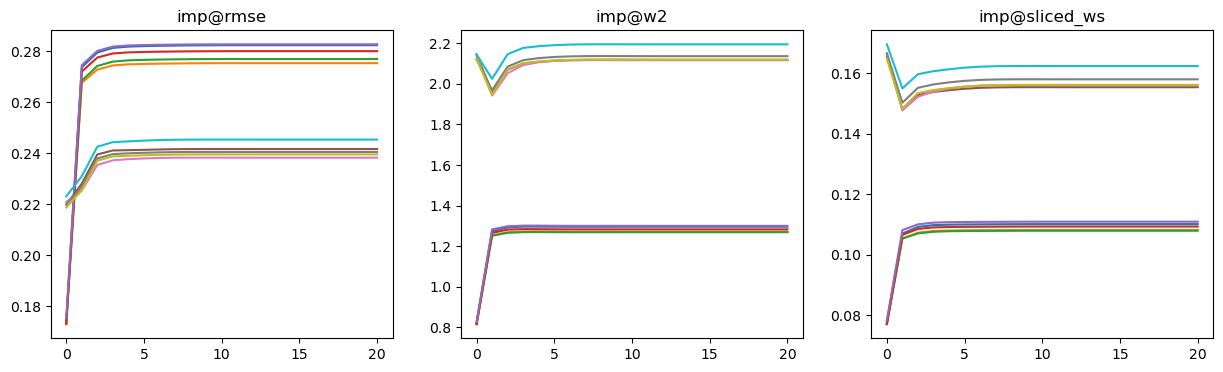

{'imp@rmse': 0.2603269840928288, 'imp@ws': 1.7103304725112296, 'imp@sliced_ws': 0.13344376333653415}


In [38]:
name = 'mnar_lr0.3_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['imputation']['clip'] = True
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:21:32.677 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 72.81328939995728


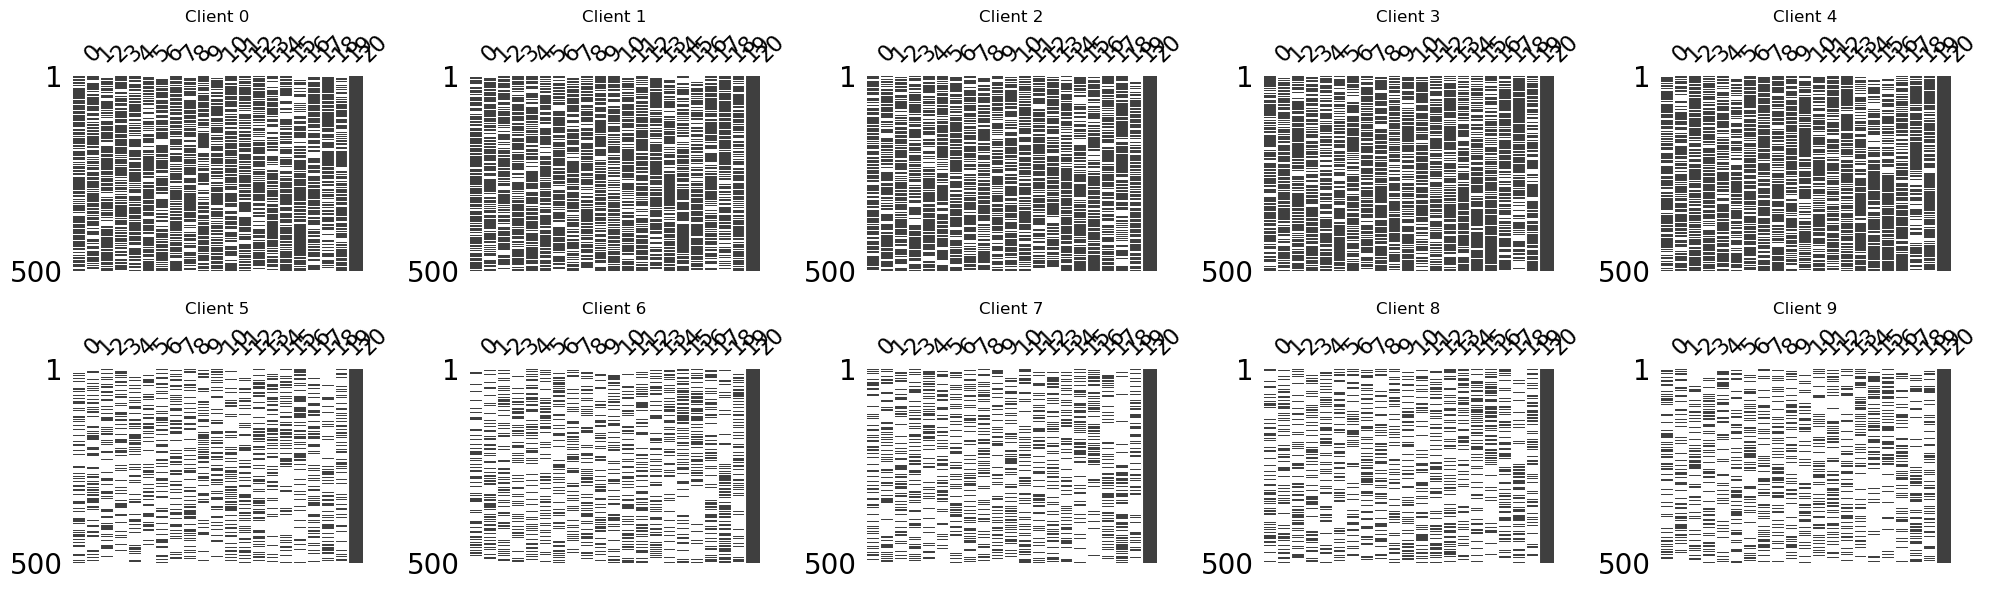

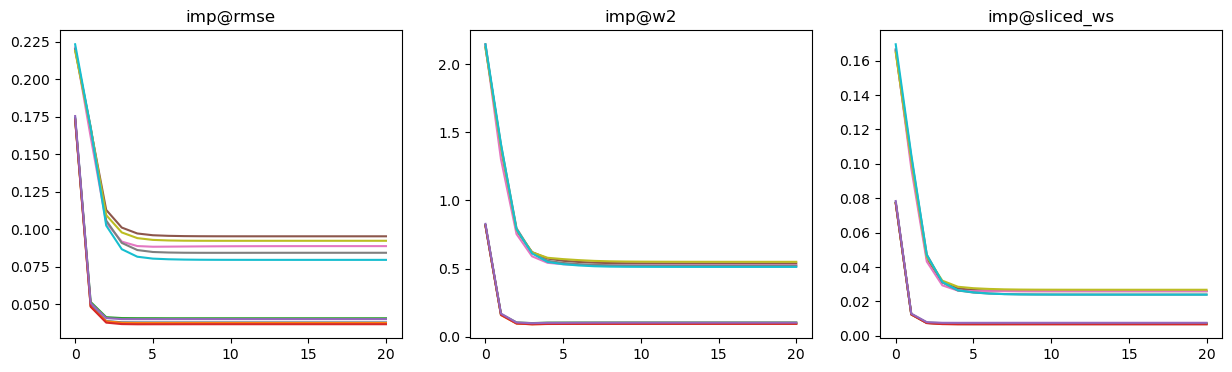

{'imp@rmse': 0.06335636838113365, 'imp@ws': 0.313415030809708, 'imp@sliced_ws': 0.016204064943634335}


In [27]:
name = 'mnar_lr0.3_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = True
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_left'
 'mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 08:30:16.581 | INFO     | src.fed_imp.sub_modules.server.base_server:run:171 - FL finished in 73.05389280000236


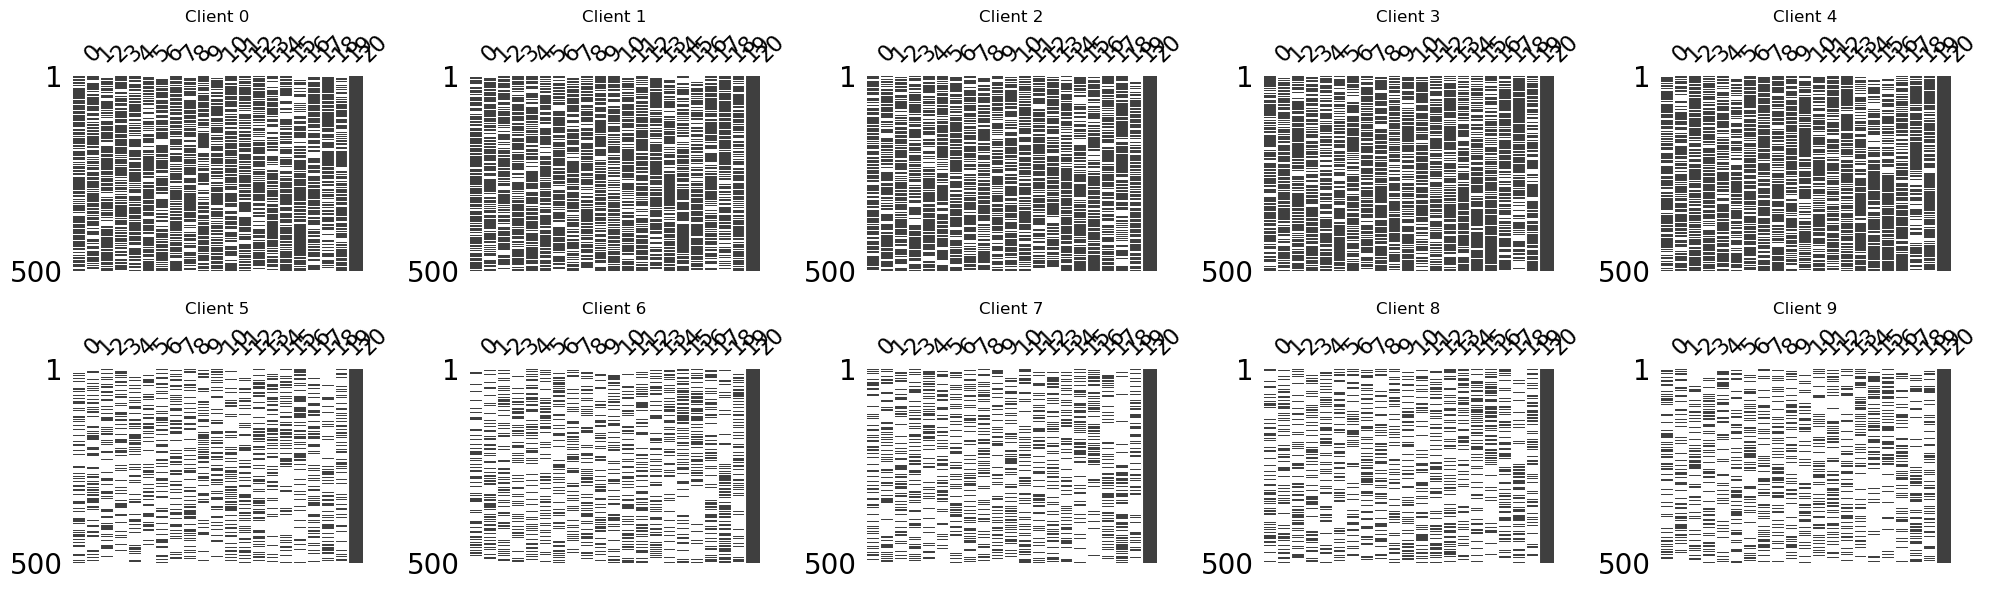

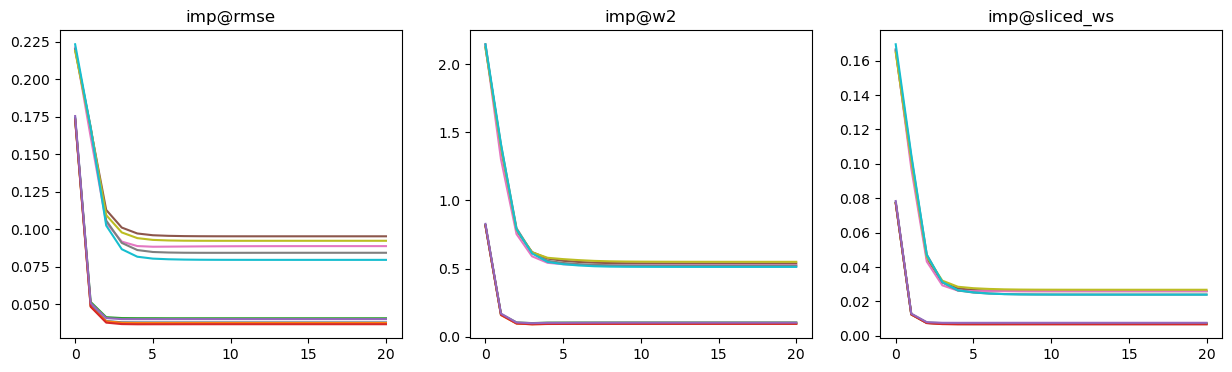

{'imp@rmse': 0.06335636838113365, 'imp@ws': 0.313415030809708, 'imp@sliced_ws': 0.016204064943634335}


In [36]:
name = 'mnar_lr0.3_fedmechw1'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'compl@mr=0.3'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## MNAR LR 0.1 0.1

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 09:55:24.228 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:55:24.228 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 09:55:54.649 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:55:54.650 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 09:56:29.777 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:56:29.778 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 09:56:33.154 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 69.81332319998182


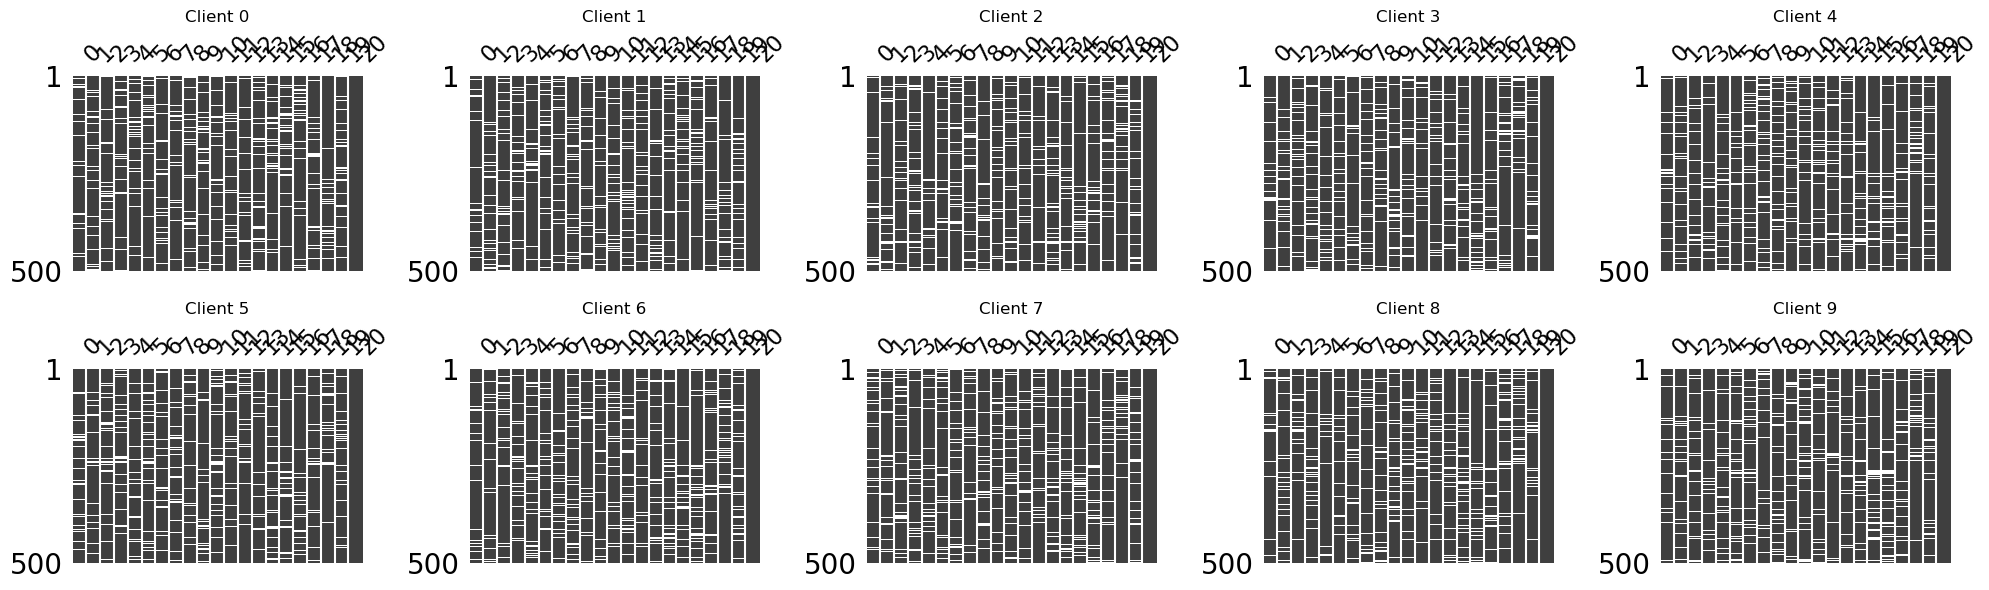

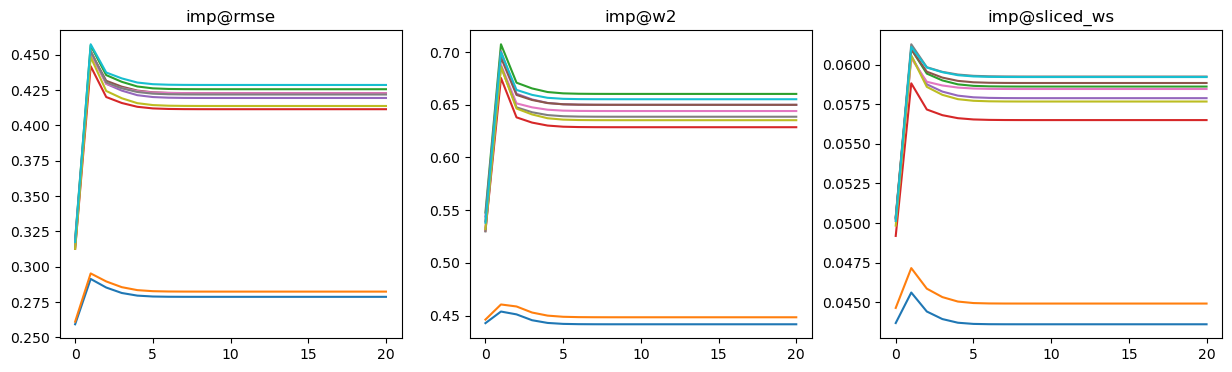

{'imp@rmse': 0.3927636943034839, 'imp@ws': 0.6052232944695161, 'imp@sliced_ws': 0.05550417432942159}


In [63]:
name = 'mnar_lr0.1_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.1'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

sample {'p': '500'}
0.01939111886755866 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right']
(11051, 21)


2023-07-22 09:52:13.405 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:52:13.406 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 09:52:45.523 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:52:45.524 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 09:53:20.325 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 09:53:20.326 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 09:53:23.923 | INFO     | src.fed_imp.sub_modules.server.base_server:run:174 - FL finished in 71.40126080007758


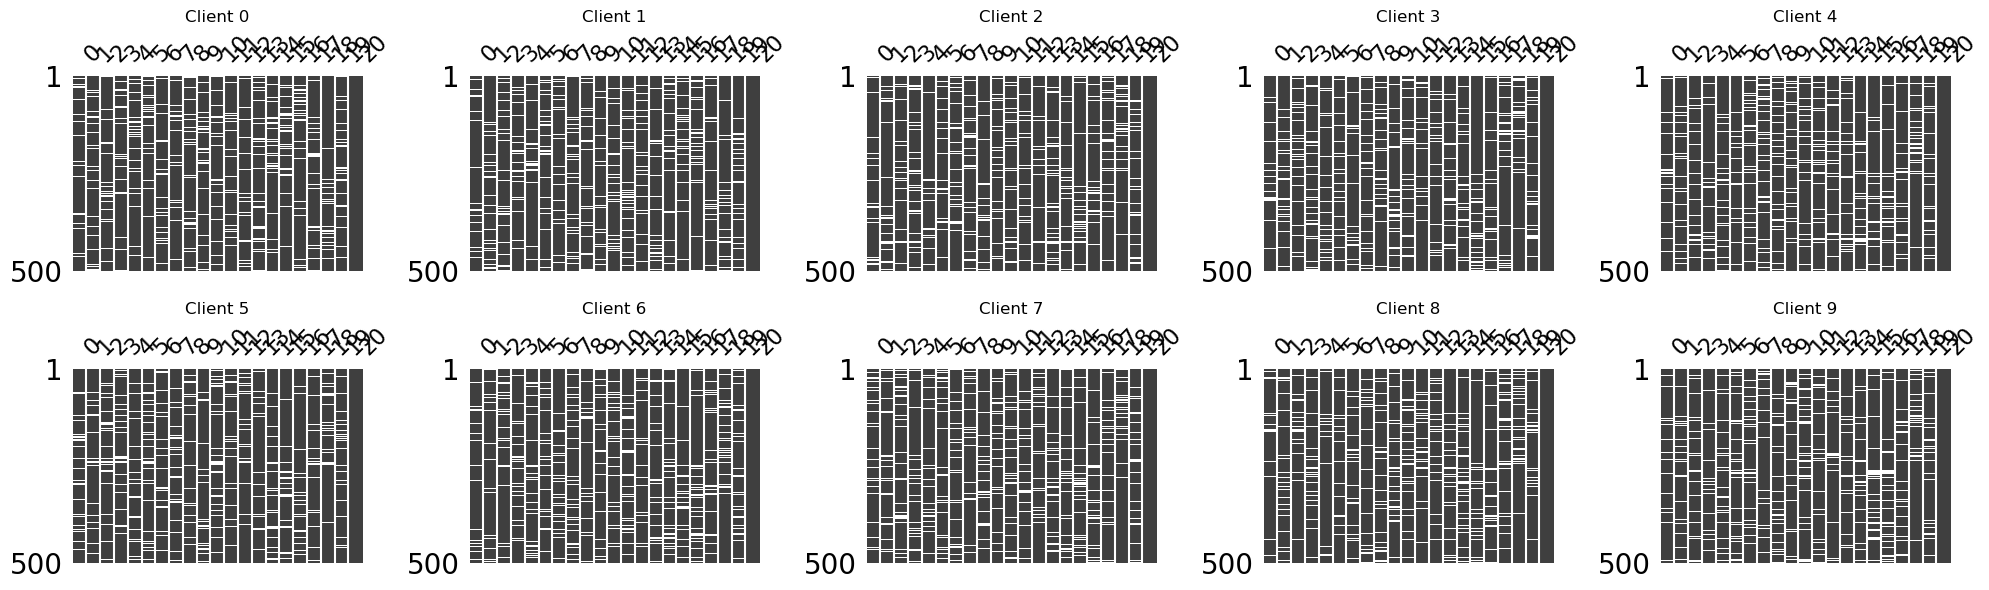

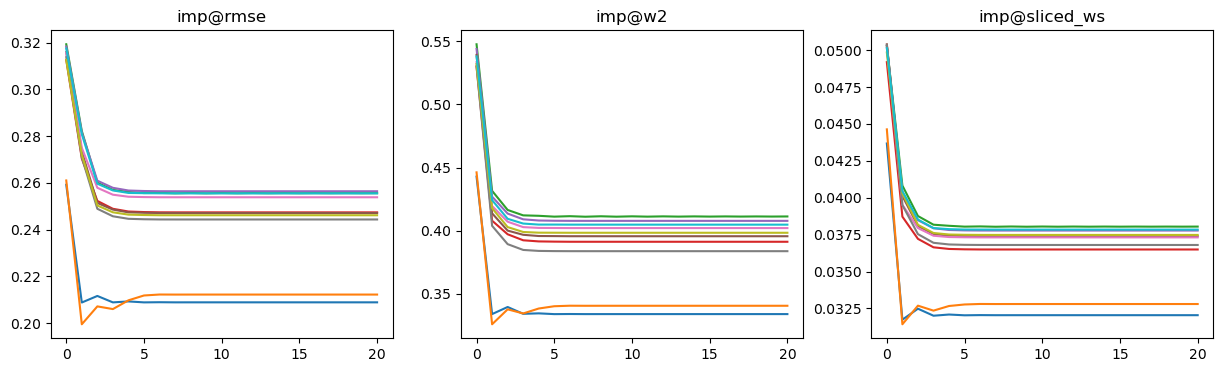

{'imp@rmse': 0.2427559588171611, 'imp@ws': 0.3868748158286545, 'imp@sliced_ws': 0.03639629192073633}


In [62]:
name = 'mnar_lr0.1_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.1'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.2'
config2['data_partition']['strategy'] = 'sample@p=500'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['imputation']['clip'] = False
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

## Exploration of Training Process

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def vis_local_model_sim_lr(tracker1, tracker2, iteration, model = 'local', metric = 'mm'):
    n_cols = 4
    n_rows = 5

    ret1, ret2 = [], []
    for feature_idx in range(n_rows * n_cols):
        clients_records1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx]
        clients_records2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx]

        if model == 'local':
            X1 = clients_records1[0].local_imp_model_params
            X2 = clients_records2[0].local_imp_model_params
            ret1.append(X1)
            ret2.append(X2)
        elif model == 'mm':
            X1 = clients_records1[0].local_mm_model_params
            X2 = clients_records2[0].local_mm_model_params
            ret1.append(X1)
            ret2.append(X2)
        else:
            raise NotImplementedError
    
    ret1 = np.array(ret1)
    ret2 = np.array(ret2)

    for client_idx in range(n_rows * n_cols):
        print("========================================================")
        X1 = ret1[:, client_idx, :]
        X2 = ret2[:, client_idx, :]
        avg = []
        for feature_idx in range(X1.shape[0]):
            x1 = X1[feature_idx]
            x2 = X2[feature_idx]
            cos_sim = cosine_similarity(x1.reshape(1, -1), x2.reshape(1, -1))[0][0]
            print(
                "client {} feature {} - cos_sim between mary left and right local model {:4f}".
                format(client_idx, feature_idx, cos_sim)
            )
            avg.append(cos_sim)
        print("Avg cos sim all features local imputation model {:.4f}".format(np.mean(avg)))

In [26]:
def vis_local_model_sim(tracker, iteration, model = 'local', metric = 'cos'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            print(cosine_sim.max(), cosine_sim.min())
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        elif metric == 'l2':
            cosine_sim = euclidean_distances(X)
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model_sim_t(tracker, iteration, model = 'local'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        cosine_sim = 1 - (cosine_similarity(X) + 1)/2
        cosine_sim = np.where(cosine_sim > 0.4, 1, 0)
        sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model(tracker, iteration, model = 'local', decomp = 'PCA'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        if decomp == 'PCA':
            pca = PCA(n_components=2)
            decomp_results = pca.fit_transform(X)
        else:
            raise NotImplementedError
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        sns.scatterplot(
            x=decomp_results[:,0], y=decomp_results[:,1],
            palette=sns.color_palette("hls", 10),
            legend="full",
            ax=ax
        )
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

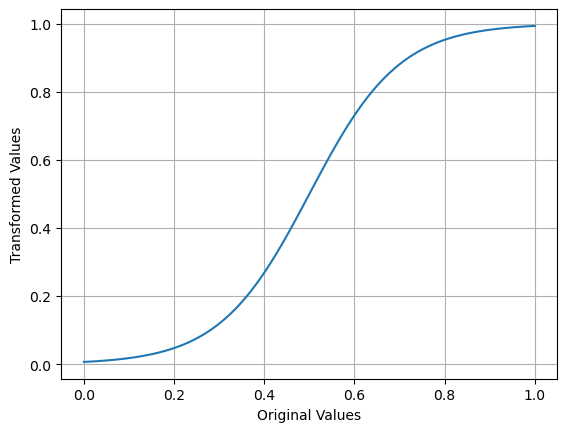

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def transform_values(values):
    return 1 - 1 / (1 + np.exp(10 * (values - 0.5)))

# Generate a sequence of values between 0 and 1
values = np.linspace(0, 1, 100)

# Apply the transformation function
transformed_values = transform_values(values)

# Plot the transformation
plt.plot(values, transformed_values)
plt.xlabel('Original Values')
plt.ylabel('Transformed Values')
plt.grid(True)
plt.show()

## Debug

In [ ]:
# fetch data inside 1.5 quantile
def fetch_data(data, feature_idx, q = 0.95):
    ret = []
    feature_data = data[:, feature_idx]
    feature_data = feature_data[(feature_data > np.quantile(feature_data, 1-q)) & (feature_data < np.quantile(feature_data, q))]

    ret.append(feature_data)
    return np.array(ret).T

In [43]:
tracker0 = trackers['mnar_lr0.3_fedmechw1']
tracker1 = trackers['mnar_lr0.3_local']
tracker2 = trackers['mnar_lr0.3_savg']

In [46]:
client5_origin_data = rets['mnar_lr0.3_fedmechw1']['data']['origin_data'][5, ...]
client5_imp_data = rets['mnar_lr0.3_fedmechw1']['data']['imputed_data'][5, ...]
client5_msk = rets['mnar_lr0.3_fedmechw1']['data']['missing_mask'][5, ...]
client5_imp_data_local = rets['mnar_lr0.3_local']['data']['imputed_data'][5, ...]
clients_imp_data_savg = rets['mnar_lr0.3_savg']['data']['imputed_data'][5,...]

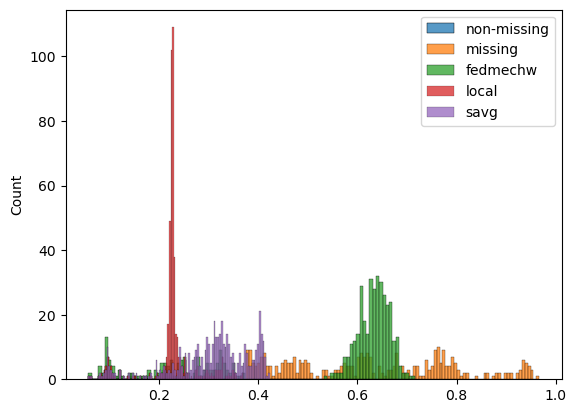

In [51]:
feature_idx = 0
sns.histplot(client5_origin_data[:, feature_idx][~client5_msk[:, feature_idx]], bins = 100, label = 'non-missing')
sns.histplot(client5_origin_data[:, feature_idx][client5_msk[:, feature_idx]], bins = 100, label = 'missing')
sns.histplot(client5_imp_data[:, feature_idx], bins = 100, label = 'fedmechw')
sns.histplot(client5_imp_data_local[:, feature_idx], bins = 100, label = 'local')
sns.histplot(clients_imp_data_savg[:, feature_idx], bins = 100, label = 'savg')
plt.legend()
#client5_imp_data1 = fetch_data(client5_imp_data, feature_idx, q = 0.99)
#sns.histplot(client5_imp_data1, bins = 200)

<Axes: ylabel='Count'>

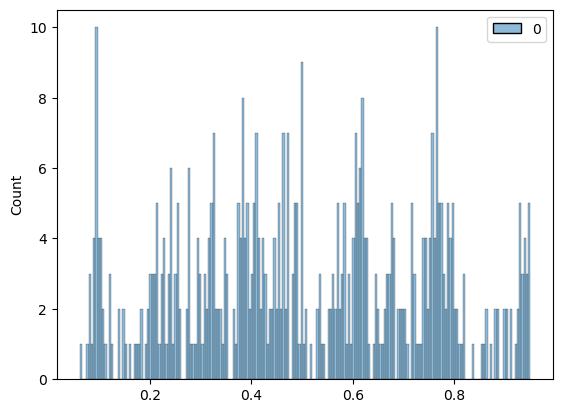

In [22]:
feature_idx = 0
feature_data = fetch_data(client5_origin_data, feature_idx, q = 1.0)
sns.histplot(feature_data, bins = 200)

0.5803601462643639 0.0
0.31841296815771525 0.0
0.43228157825200897 -2.220446049250313e-16
0.5729864385920513 0.0
0.6307808197336906 -2.220446049250313e-16
0.54876000170871 0.0
0.6774747491728252 -2.220446049250313e-16
0.7473128427262314 -2.220446049250313e-16
0.7740185417066454 0.0
0.7232416330262514 0.0
0.3112134457112955 0.0
0.13203337775919233 0.0
0.1469174068287844 0.0
0.05571369762543266 0.0
0.11495633017444096 0.0
0.19818404550477564 -2.220446049250313e-16
0.021090599998431547 0.0
0.18409175110115328 0.0
0.15355482649036256 0.0
0.10252195274536713 0.0


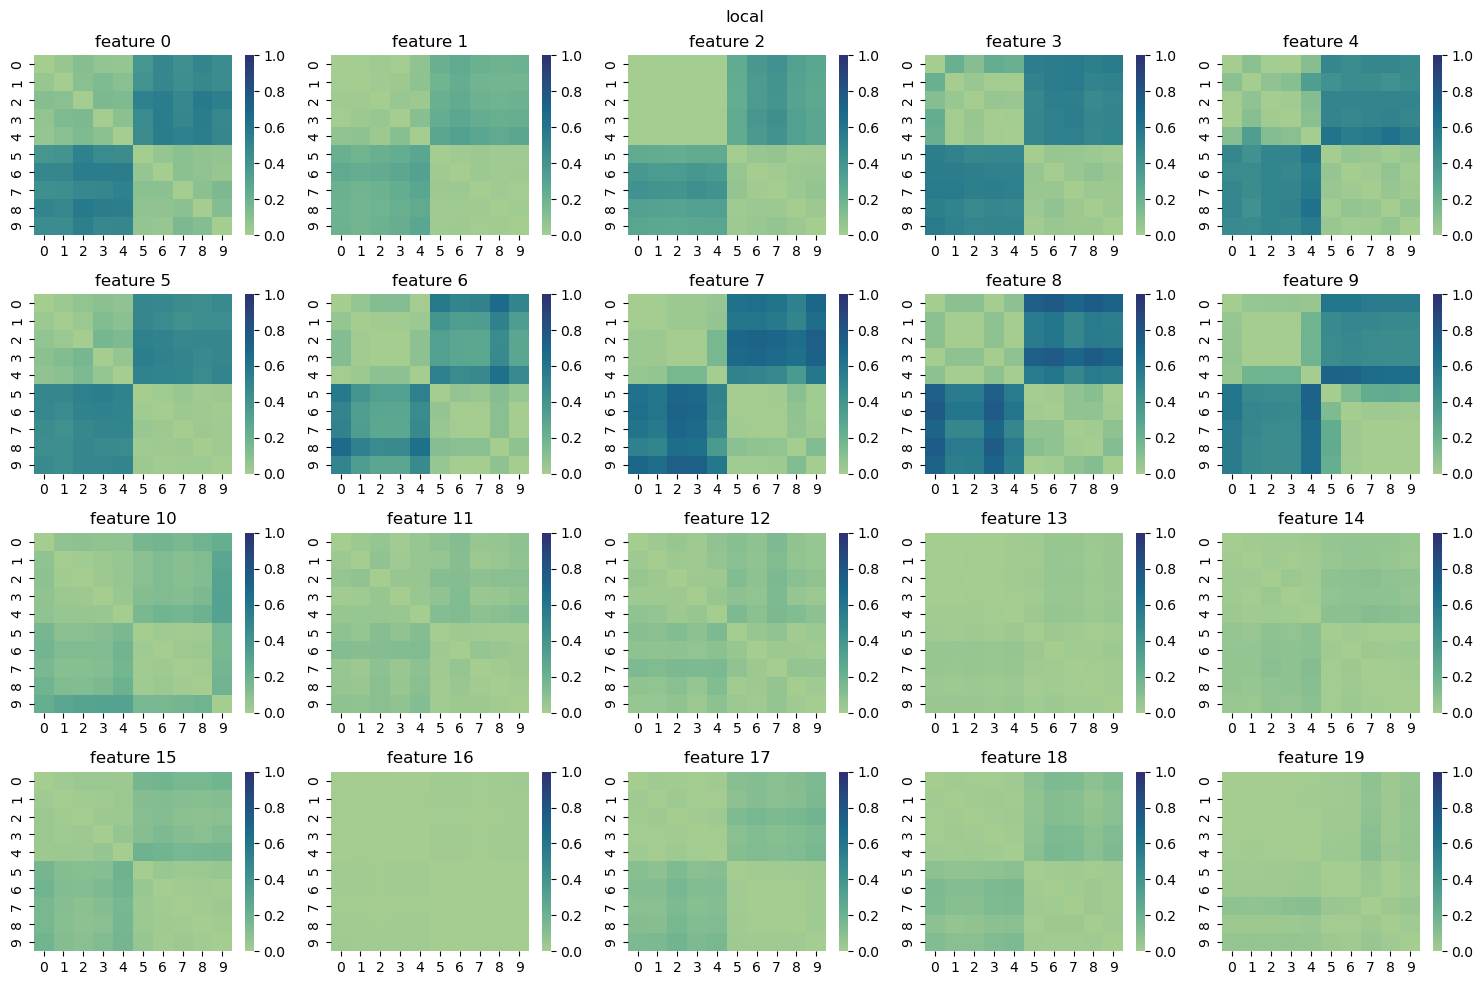

In [85]:
vis_local_model_sim(tracker0, iteration = 2, model='local')

0.9963939594946666 -2.220446049250313e-16
0.9431521018869486 0.0
0.9940967616046654 0.0
0.9965861540483689 -2.220446049250313e-16
0.9966713349522767 -2.220446049250313e-16
0.9944241829780114 -2.220446049250313e-16
0.9972108982617098 -2.220446049250313e-16
0.9962235385976931 -2.220446049250313e-16
0.997073208911451 0.0
0.917472910271713 -2.220446049250313e-16
0.9896359990438772 0.0
0.9638404023224139 0.0
0.9553112094988783 0.0
0.9551083730701052 0.0
0.9487884927700952 -2.220446049250313e-16
0.9315533320644959 0.0
0.9454778255726426 0.0
0.9434655164782455 0.0
0.9816275572897402 0.0
0.9261836483461502 0.0


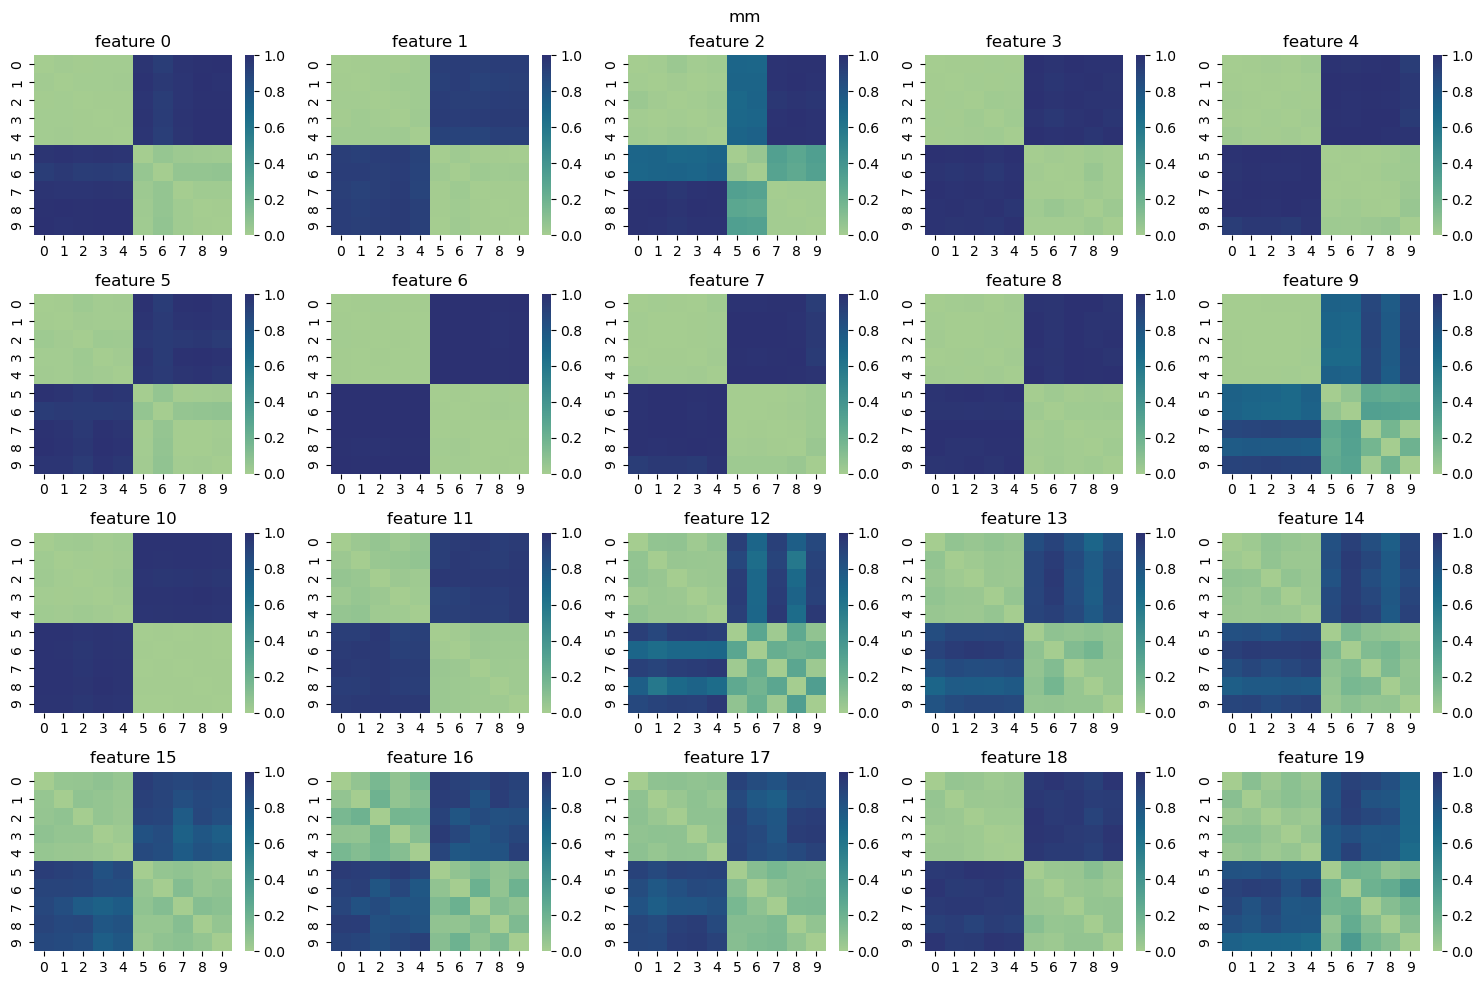

In [72]:
vis_local_model_sim(tracker0, iteration = 20, model='mm')

In [82]:
vis_local_model_sim(tracker2, iteration = 1, model = 'local')

NameError: name 'tracker2' is not defined

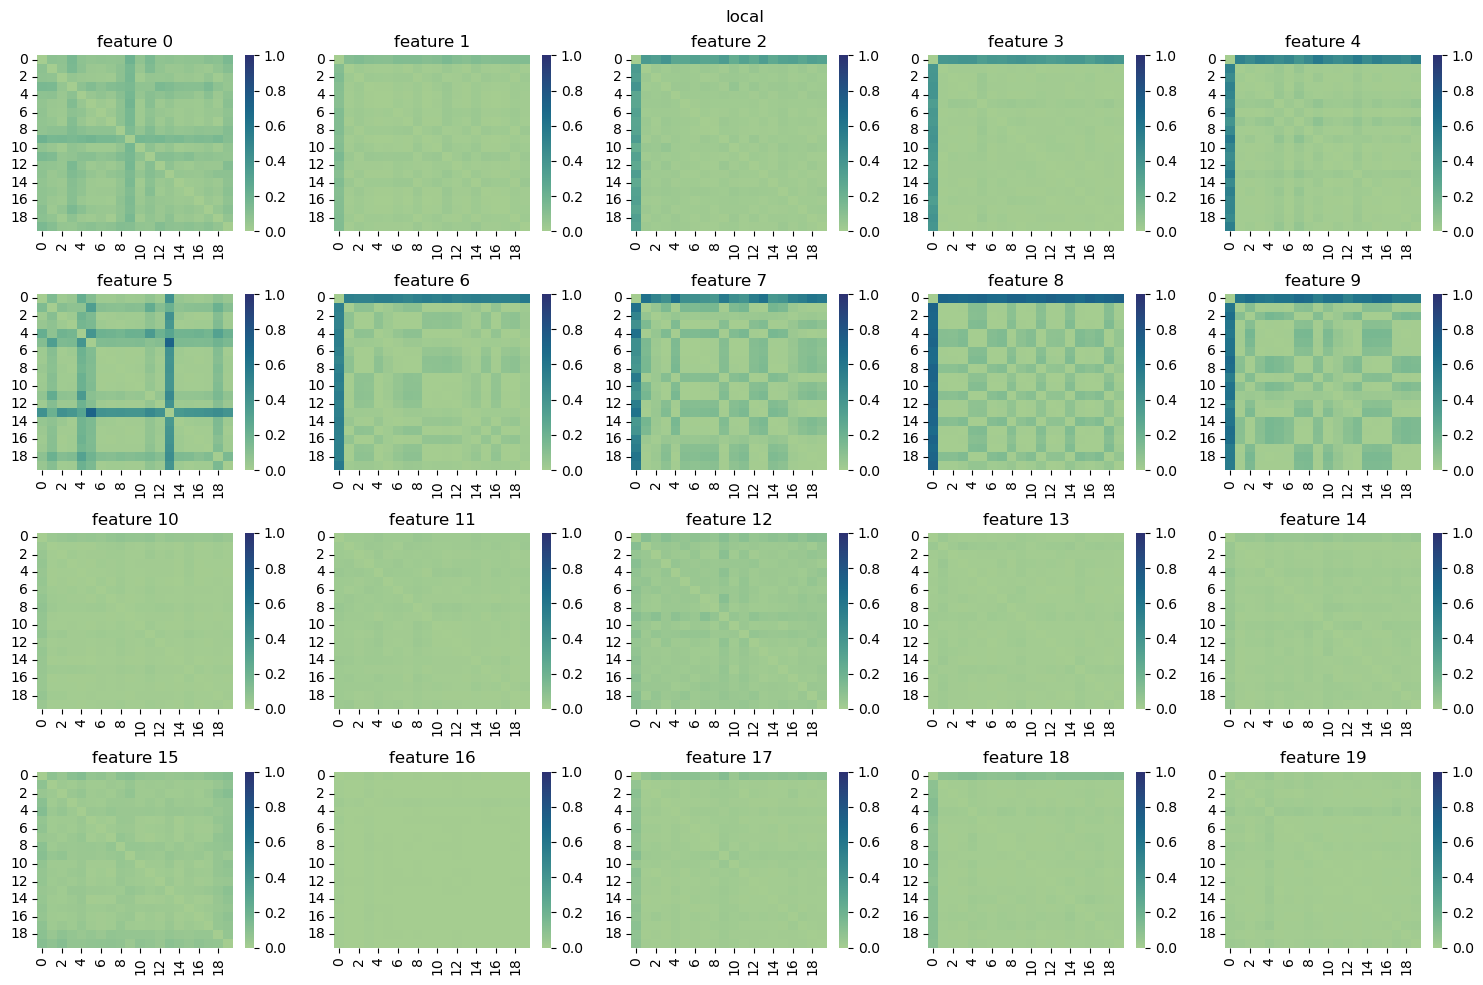

In [805]:
vis_local_model_sim(tracker2, iteration = 5, model = 'local')

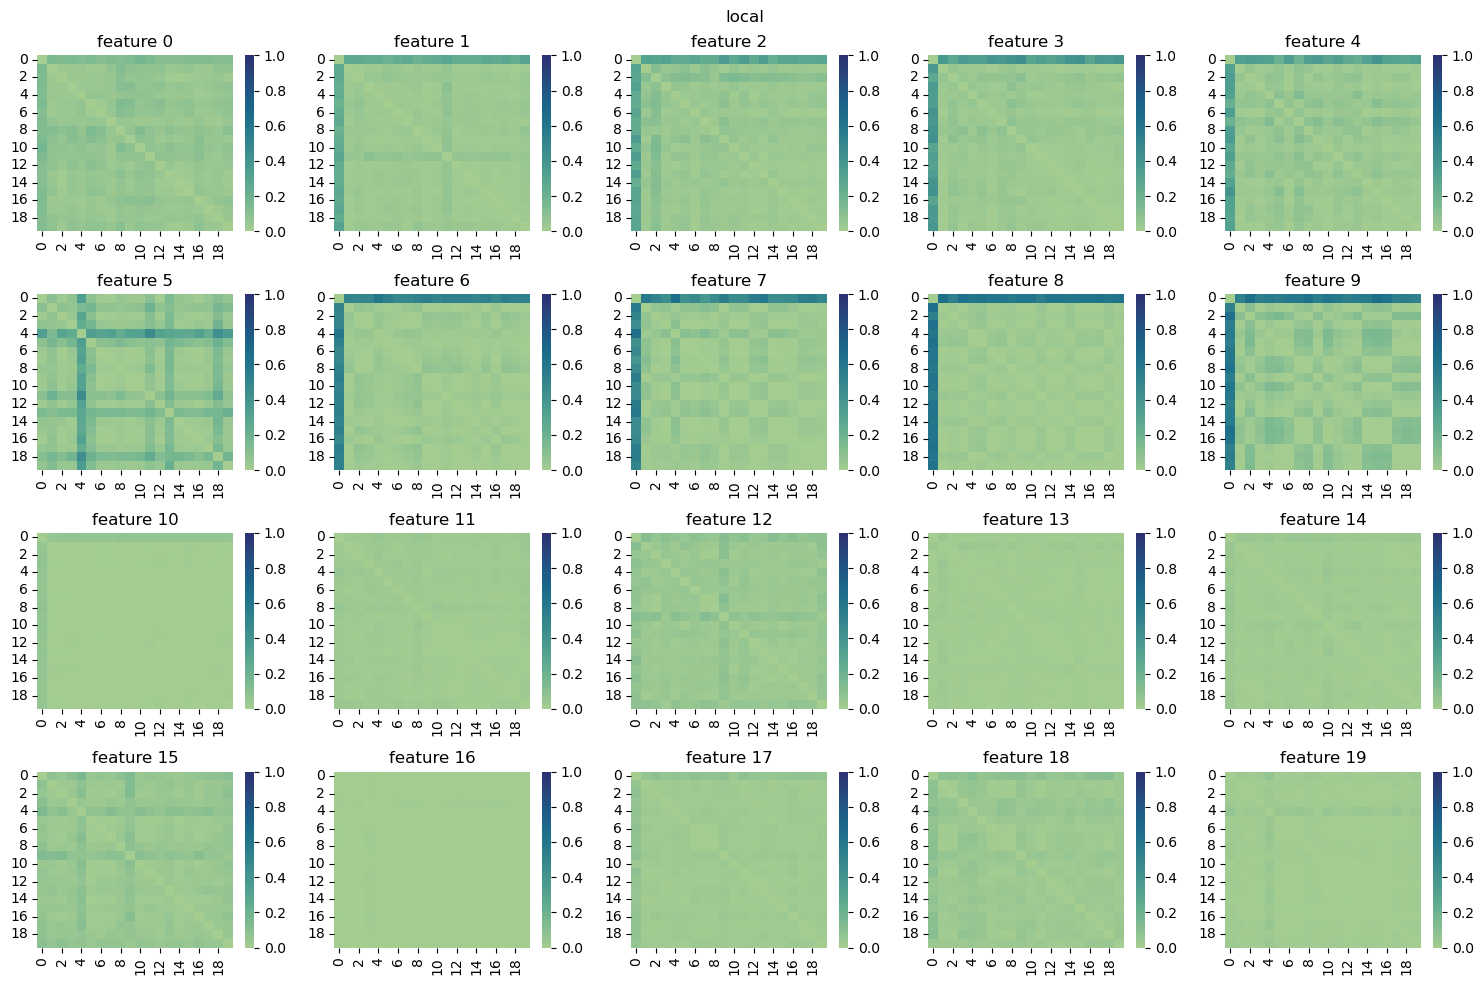

In [806]:
vis_local_model_sim(tracker3, iteration = 1, model='local')

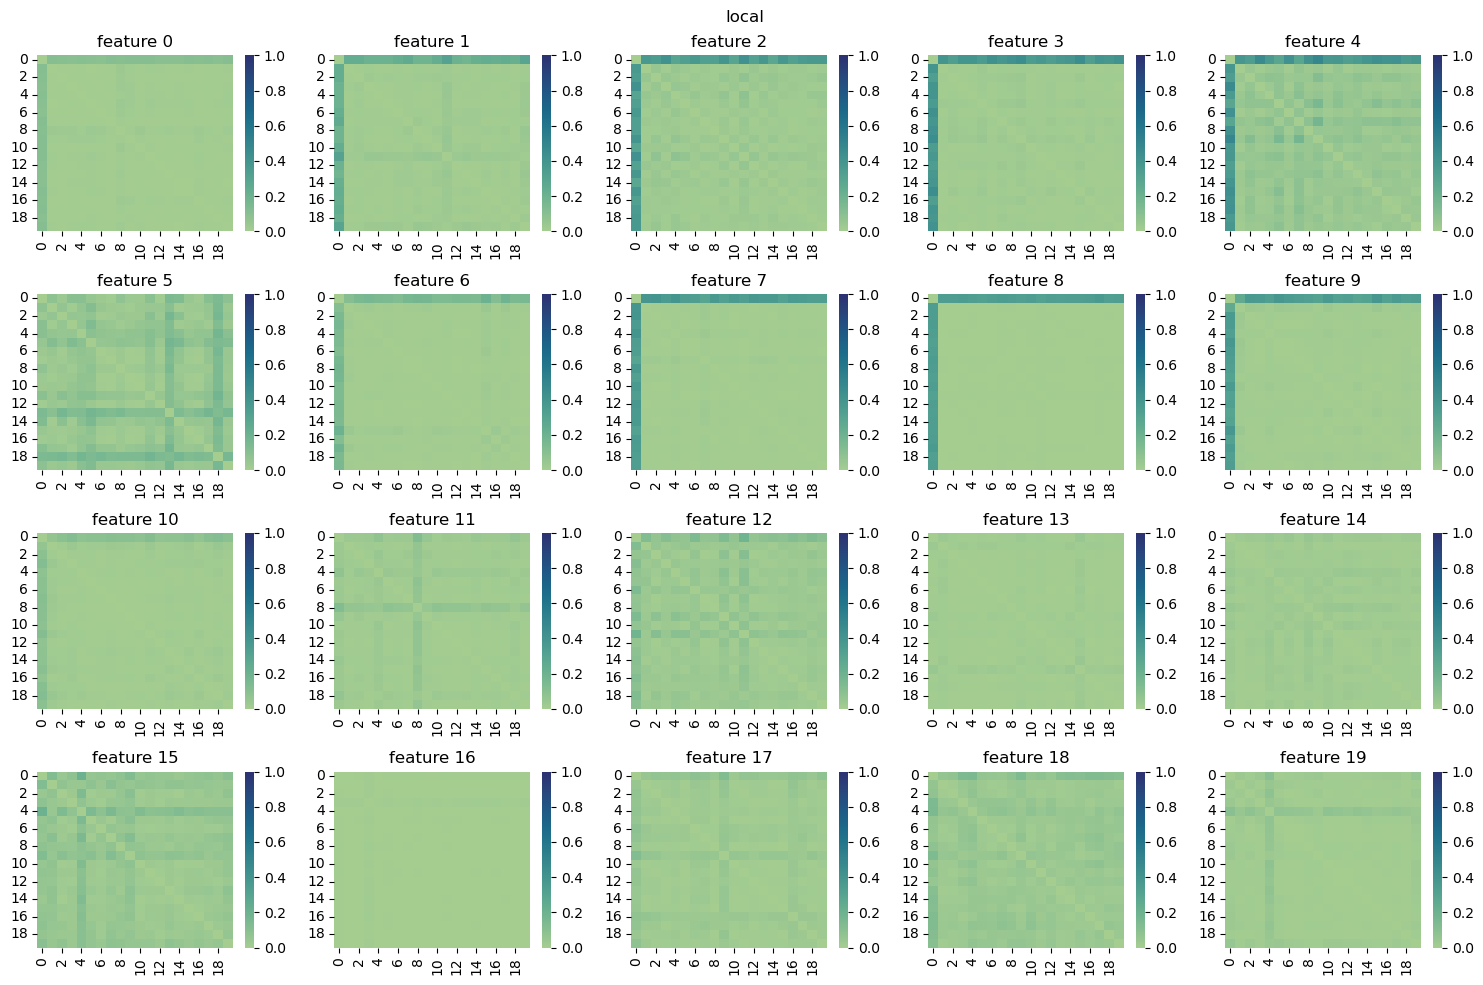

In [807]:
vis_local_model_sim(tracker, iteration = 20, model = 'local')

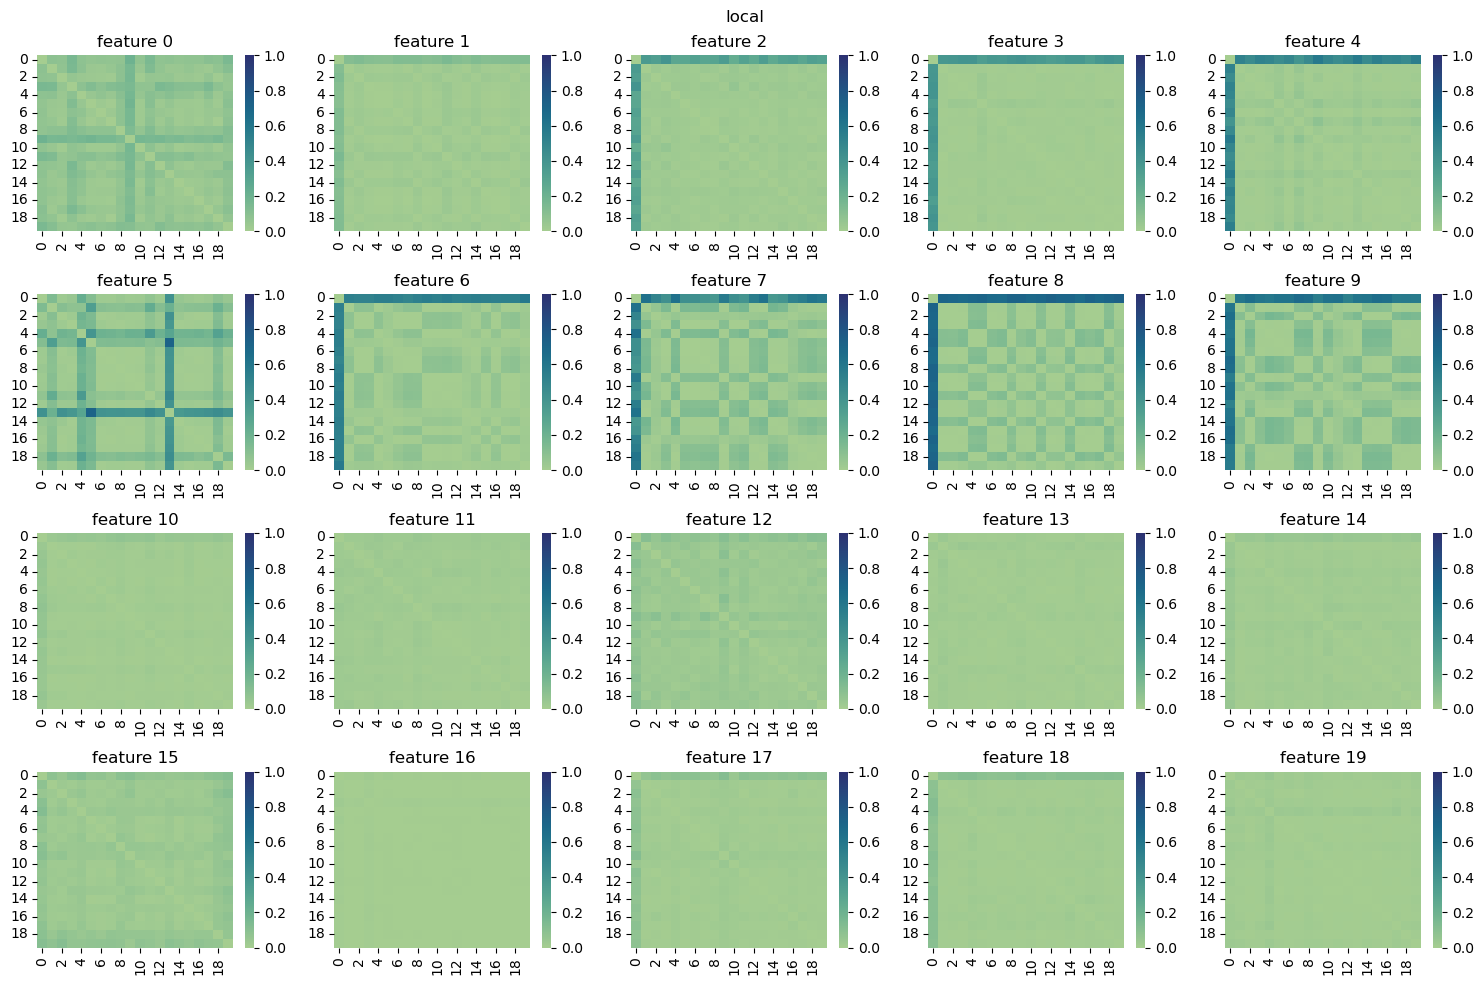

In [808]:
vis_local_model_sim(tracker2, iteration = 20, model = 'local')

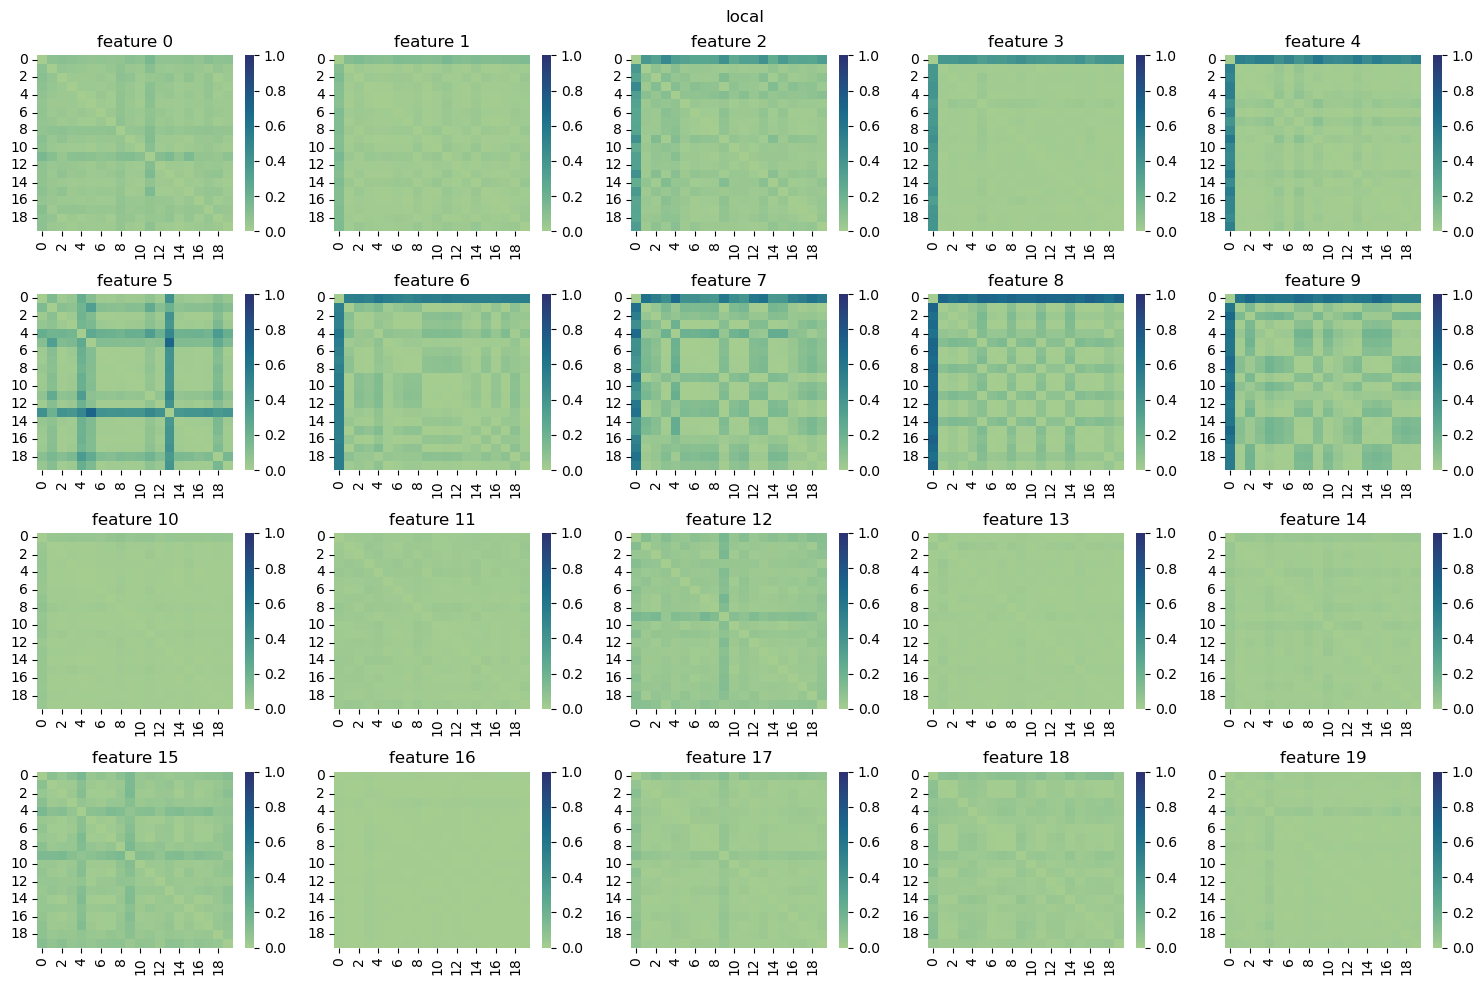

In [809]:
vis_local_model_sim(tracker3, iteration = 20, model = 'local')

#### Debug

In [221]:
def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

In [218]:
calculate_dis(0, tracker, tracker2)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [224]:
calculate_dis(1, tracker, tracker2, what = 'local_model')

0.0
1.6337764897152576
1.5702846497335994
0.5004458163916409
1.3448007010580283
1.9703069642747753
7.092822298471598
4.107754167615582
2.3113705599253667
2.6584593576326214
3.5720236606869196
0.6173539228937241
0.8044787428567401
0.5814388400454863
0.5877724712278766
1.1204952547227718
0.7345322421861542
1.1153722099686756
2.1486559810471793
0.793473354314416


#### Mechanism Model

##### Local

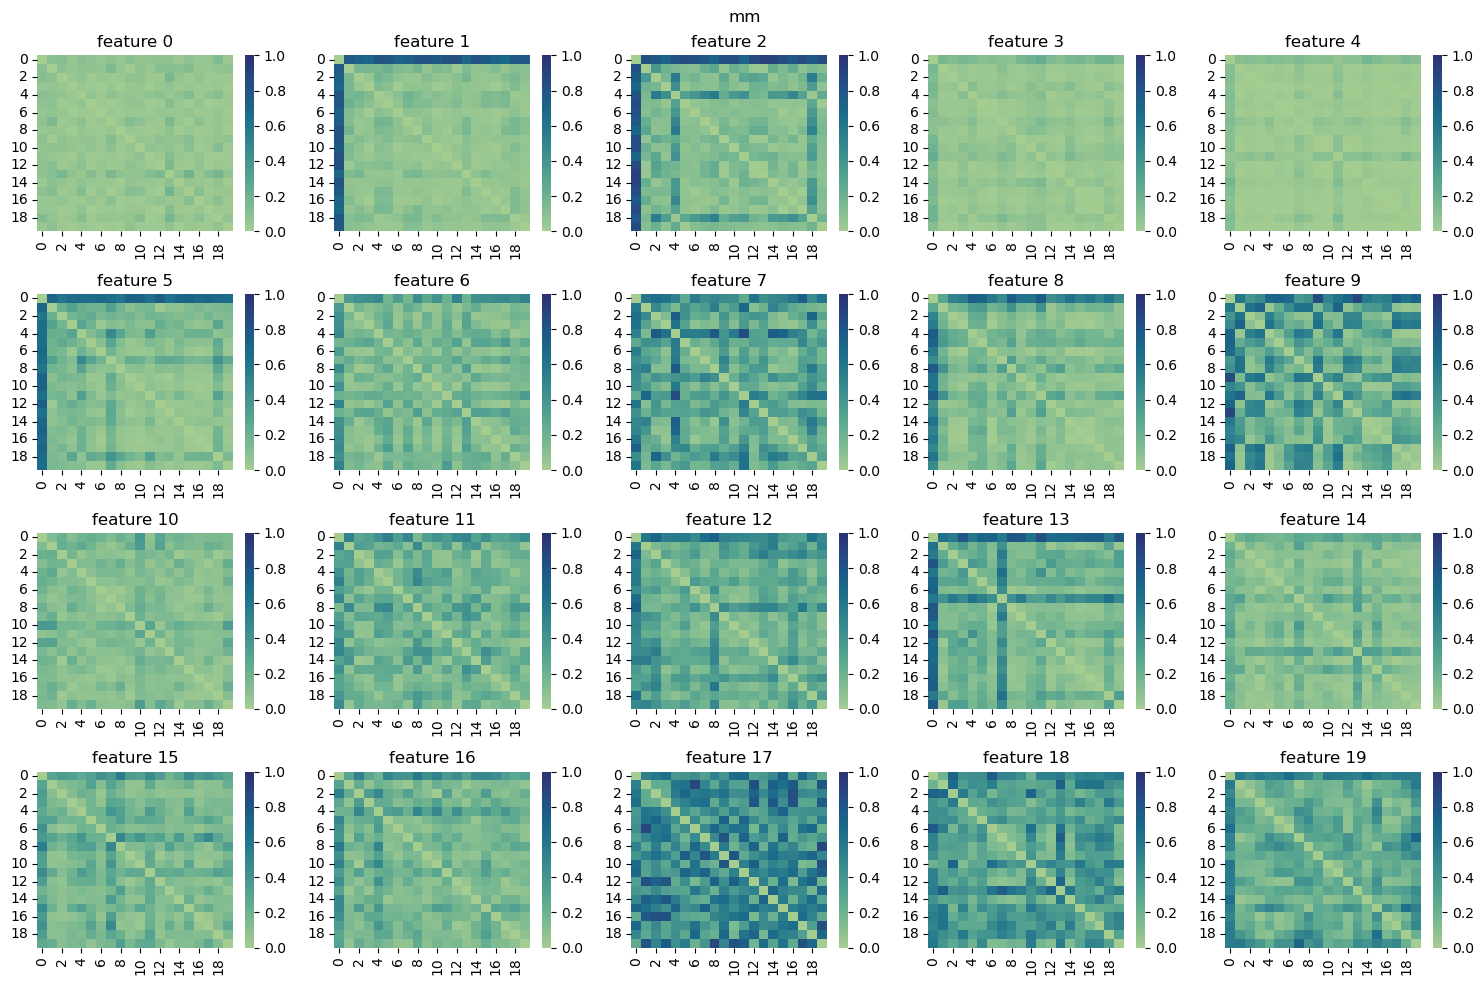

In [810]:
vis_local_model_sim(tracker0, iteration = 1, model = 'mm')

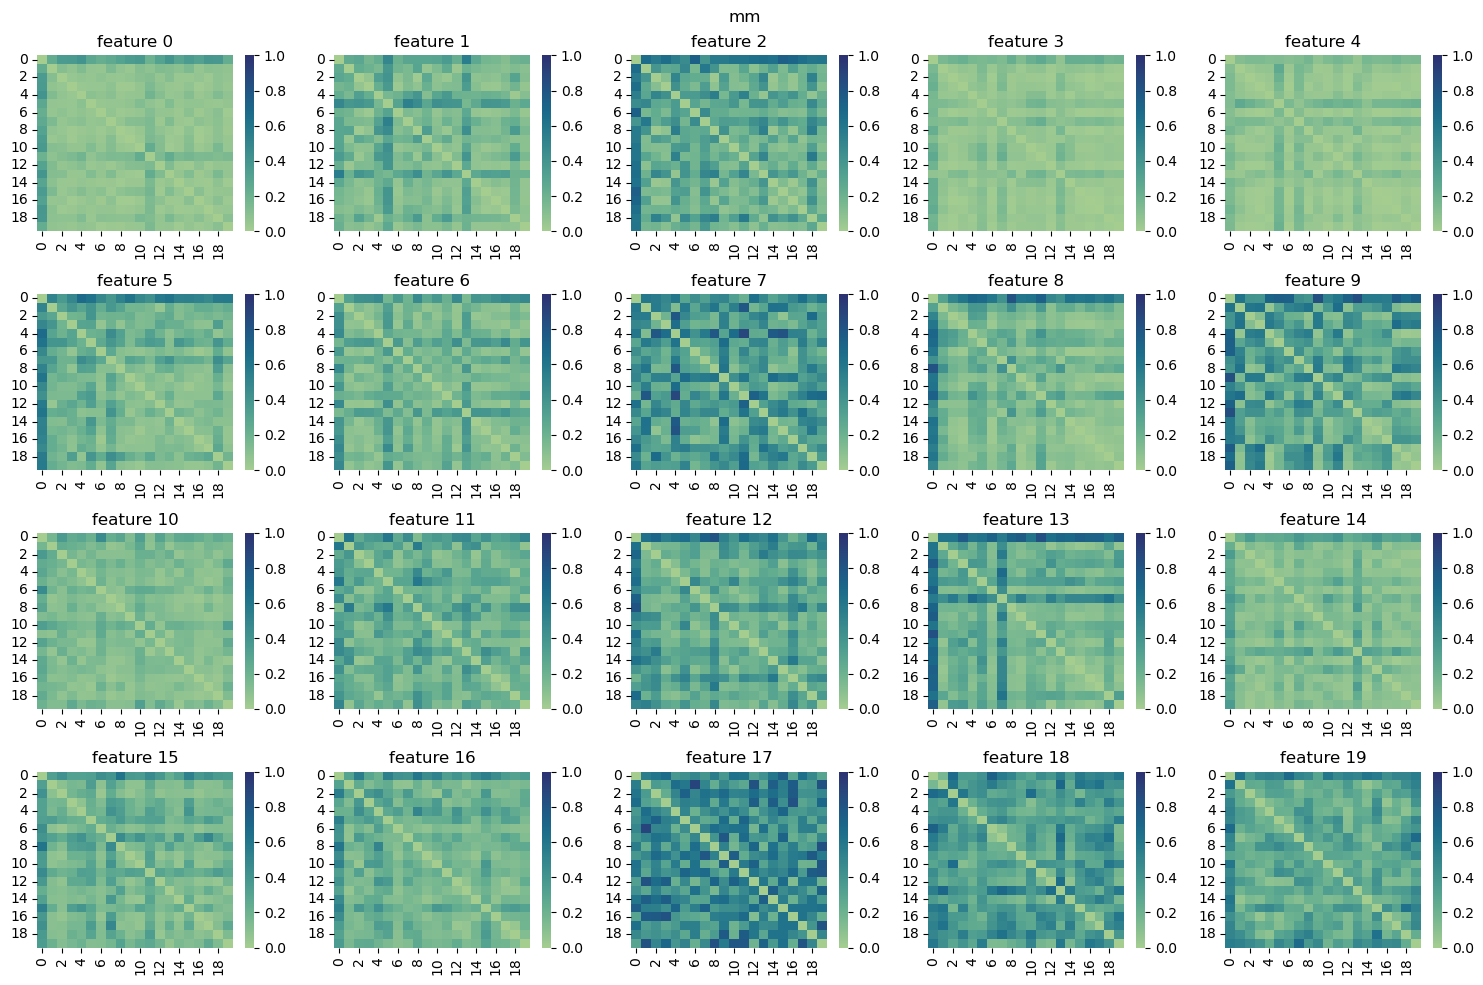

In [811]:
vis_local_model_sim(tracker0, iteration = 4, model = 'mm')

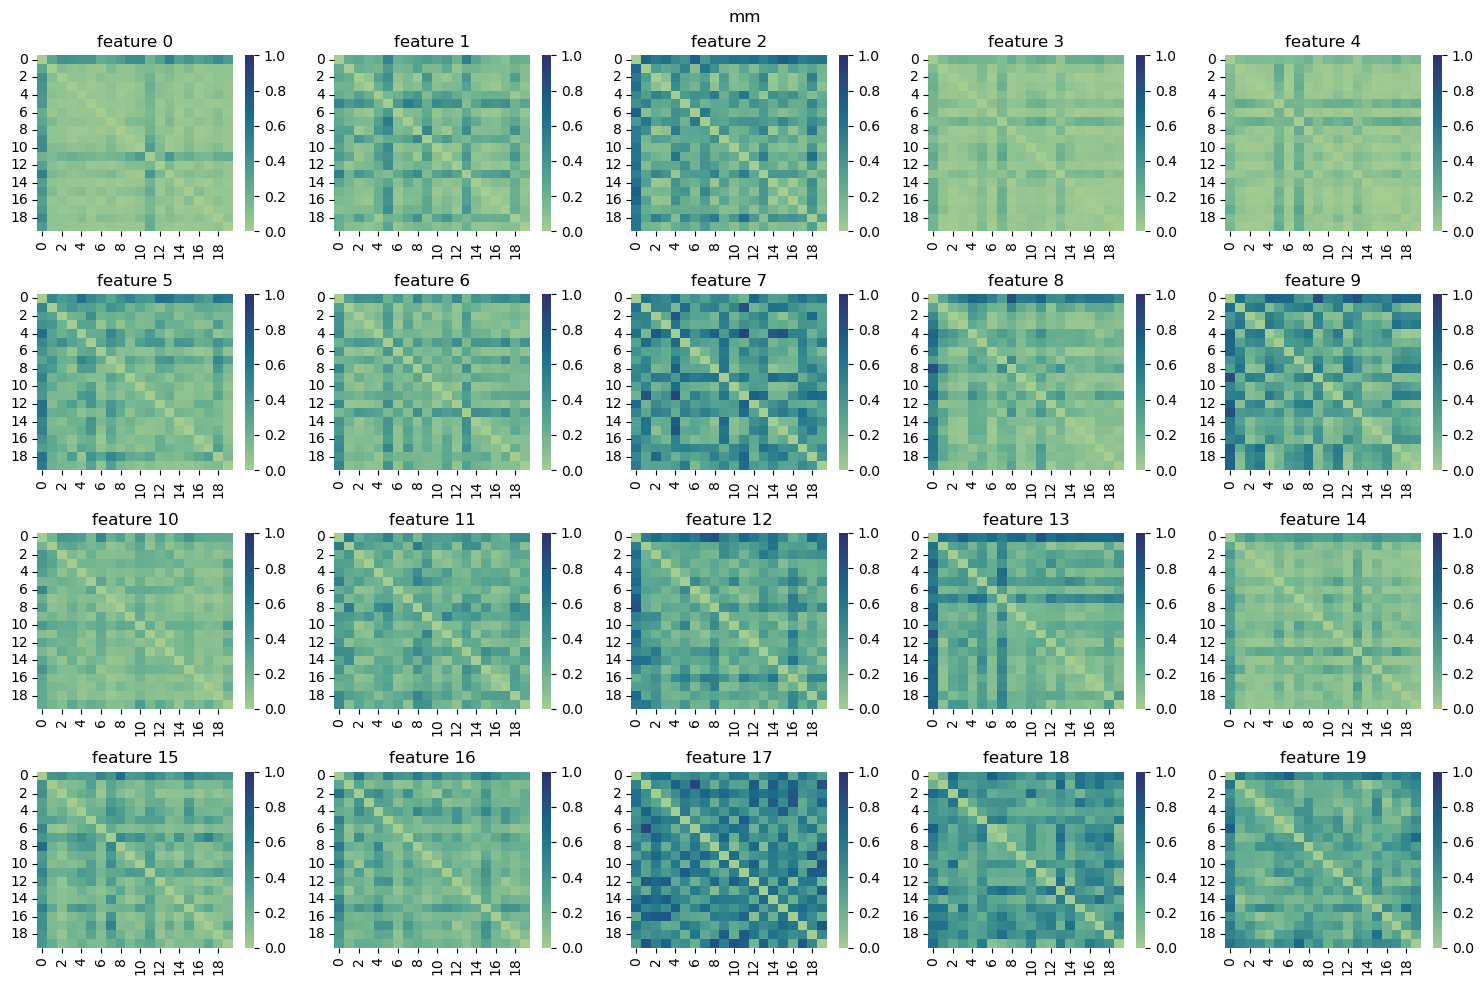

In [812]:
vis_local_model_sim(tracker0, iteration = 20, model='mm')

##### SimpleAVG

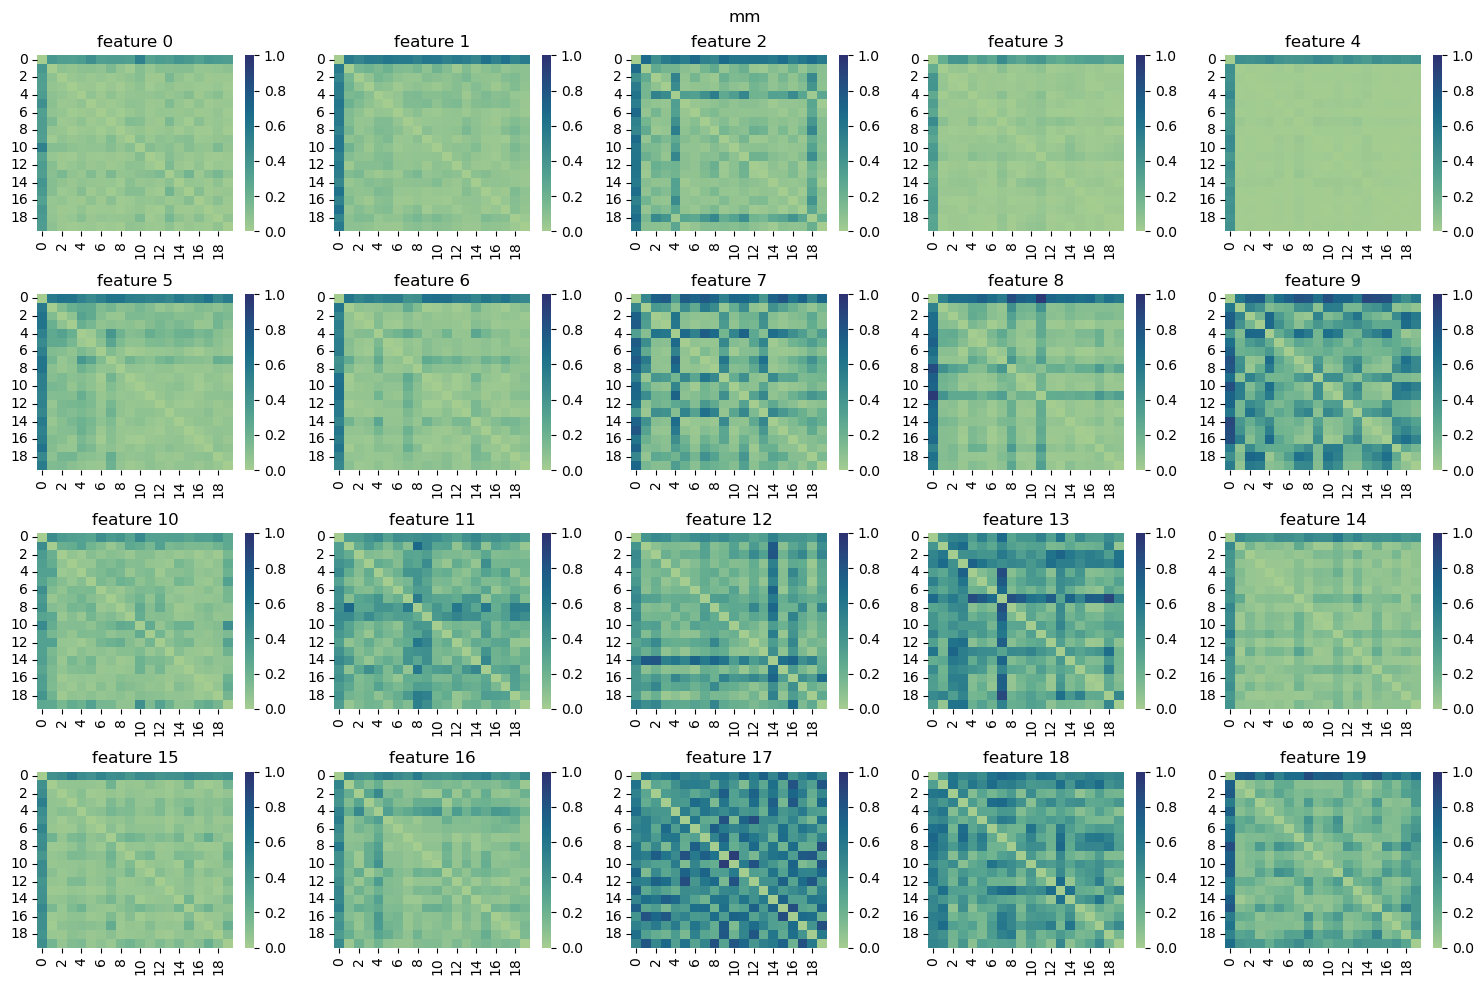

In [813]:
vis_local_model_sim(tracker, iteration = 1, model='mm')

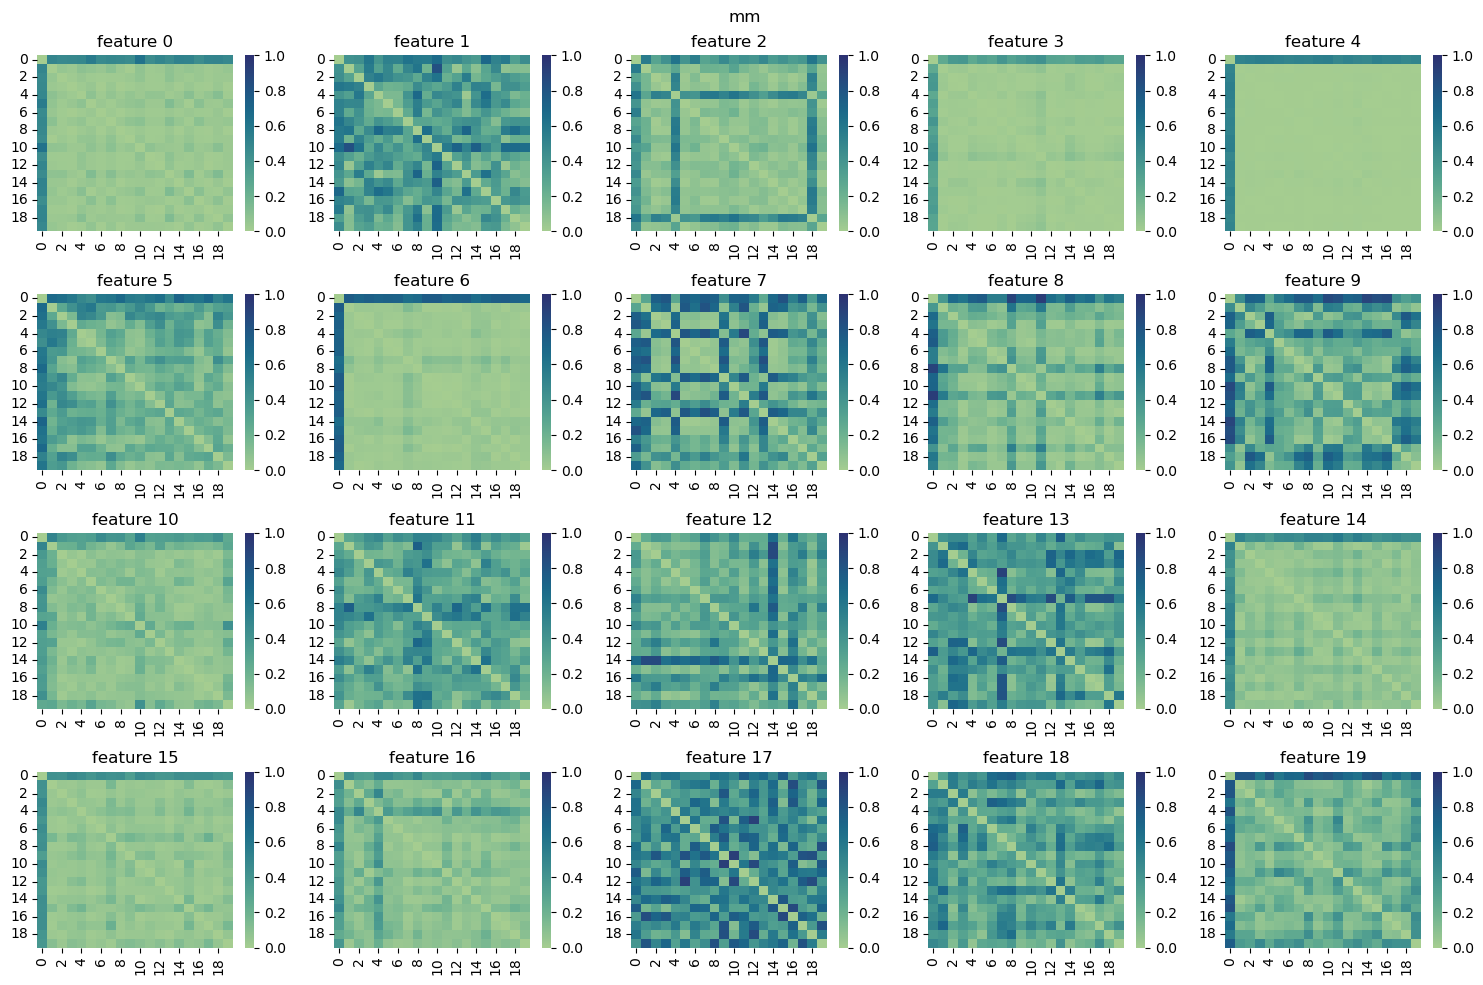

In [814]:
vis_local_model_sim(tracker, iteration = 3, model='mm')

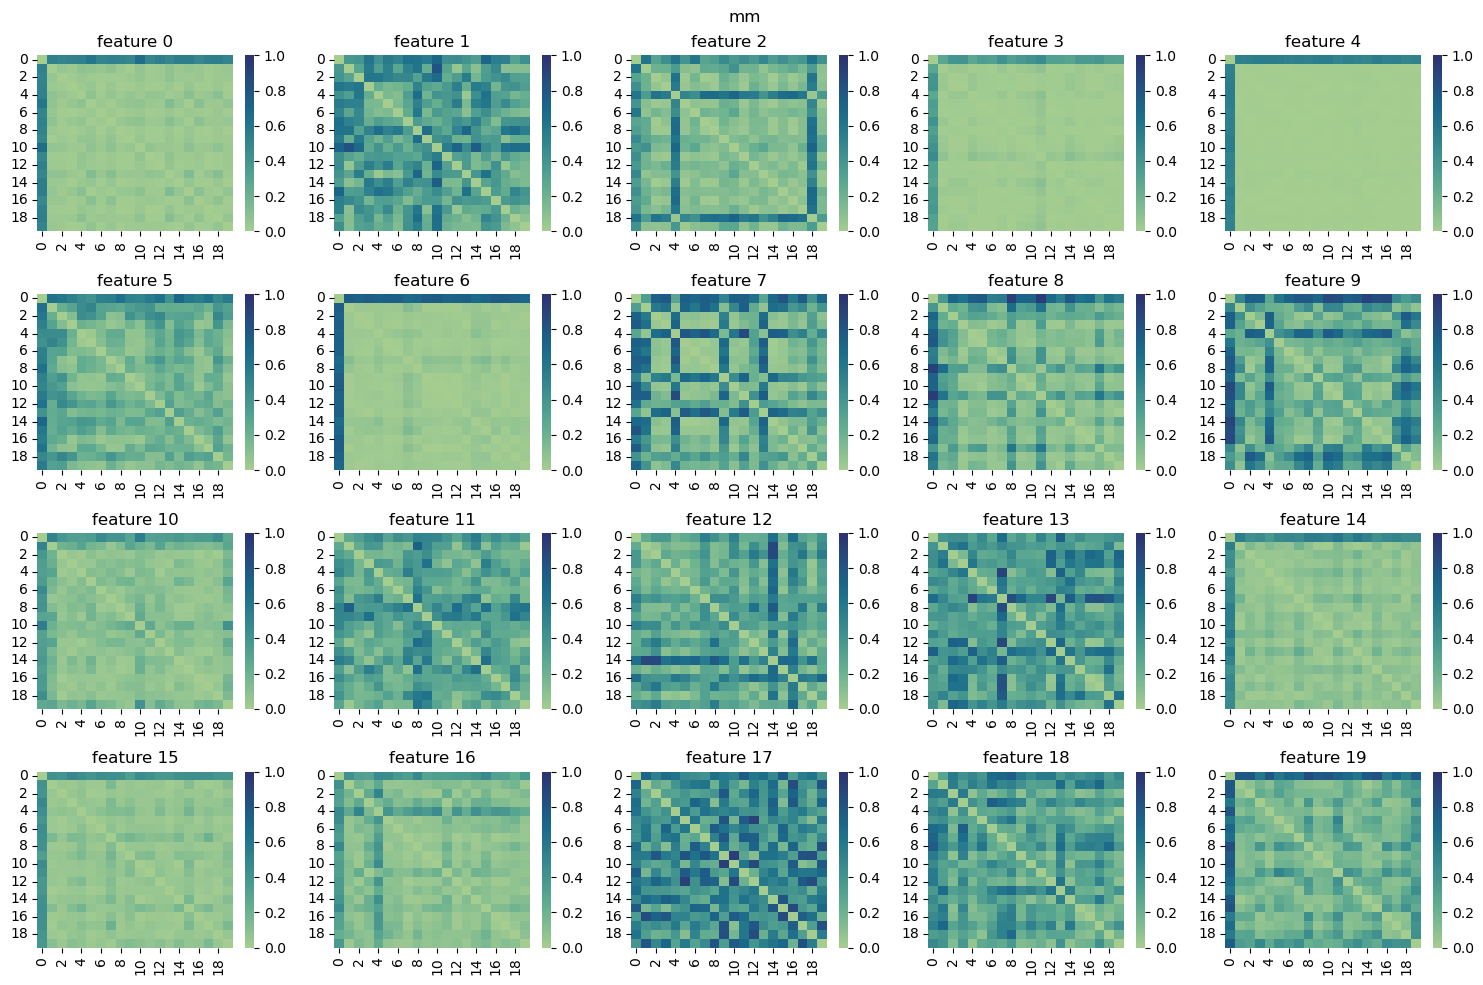

In [815]:
vis_local_model_sim(tracker, iteration = 5, model='mm')

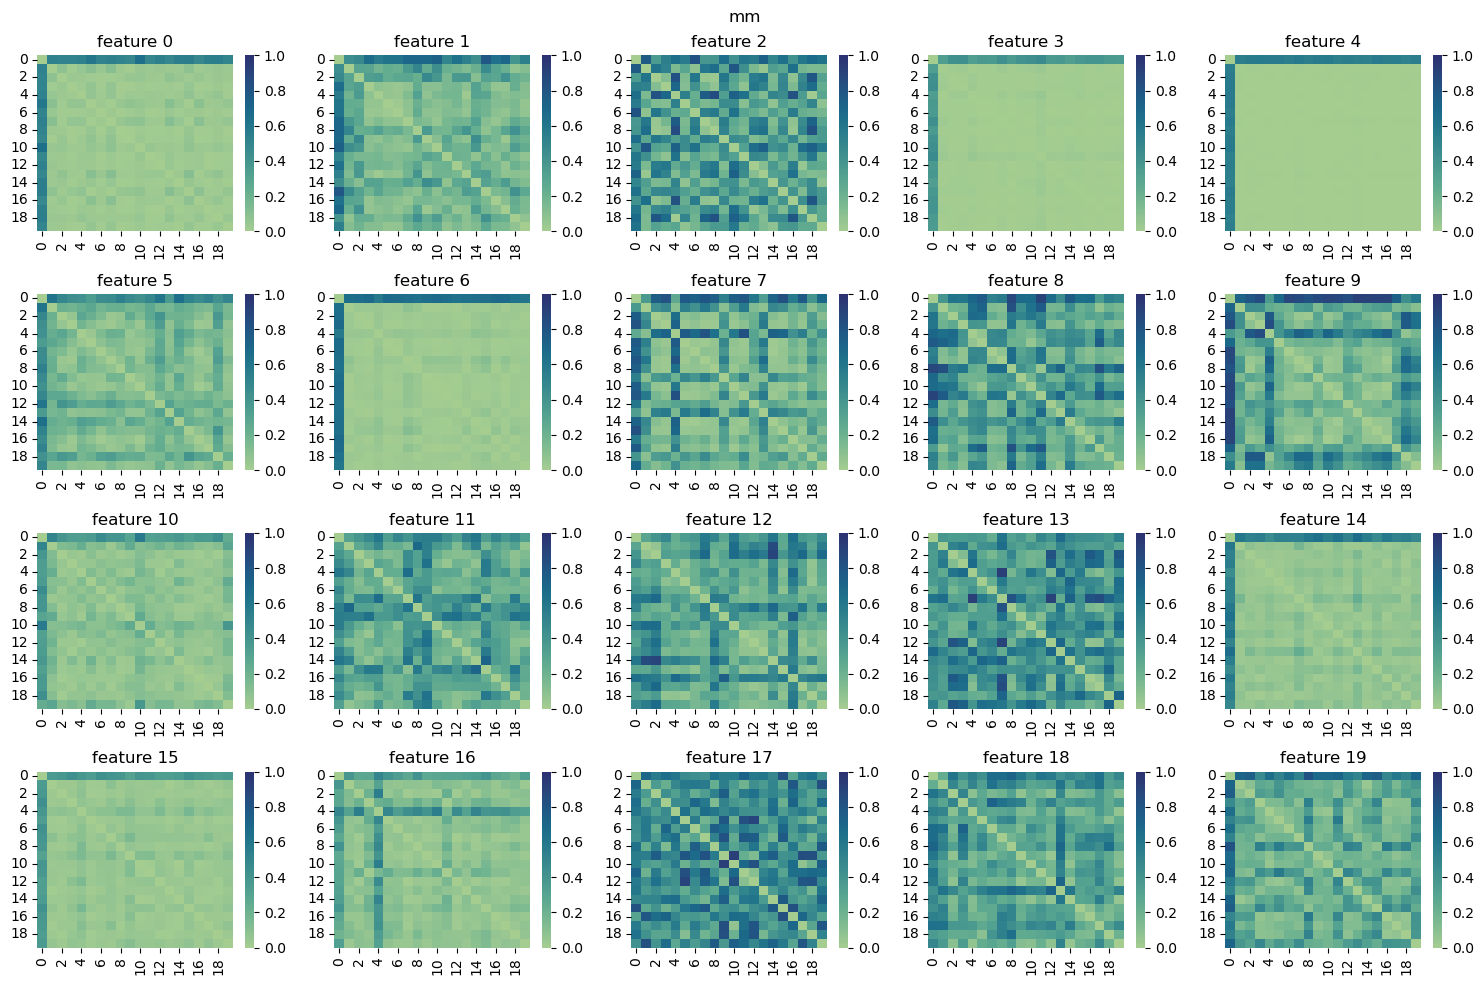

In [816]:
vis_local_model_sim(tracker, iteration = 20, model='mm')

##### Complementary

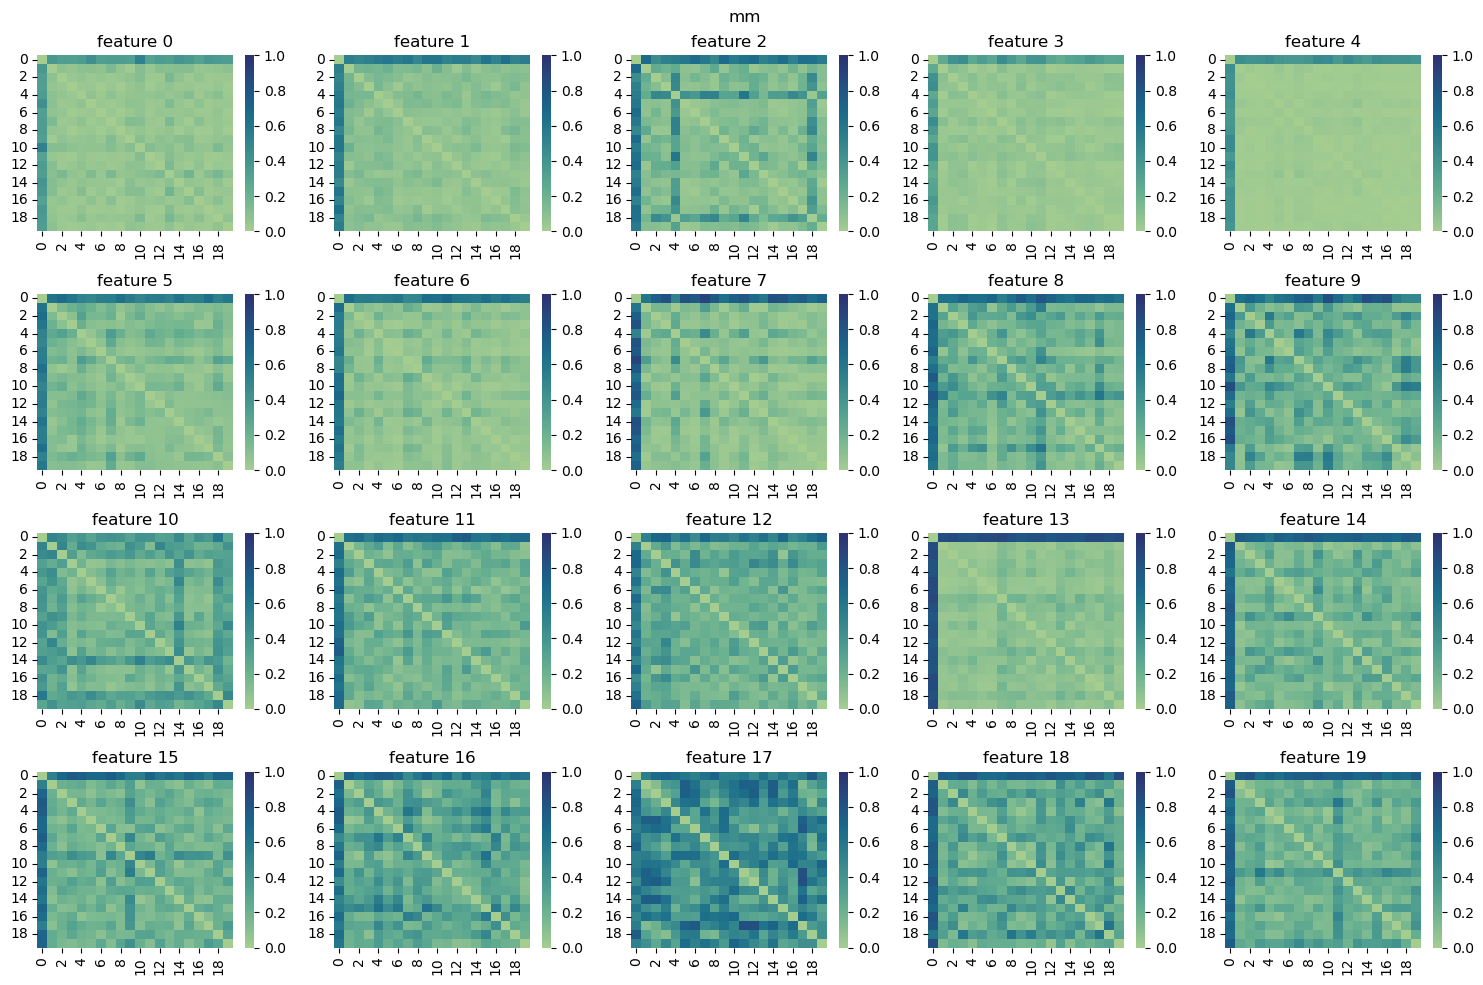

In [817]:
vis_local_model_sim(tracker2, iteration = 1, model='mm')

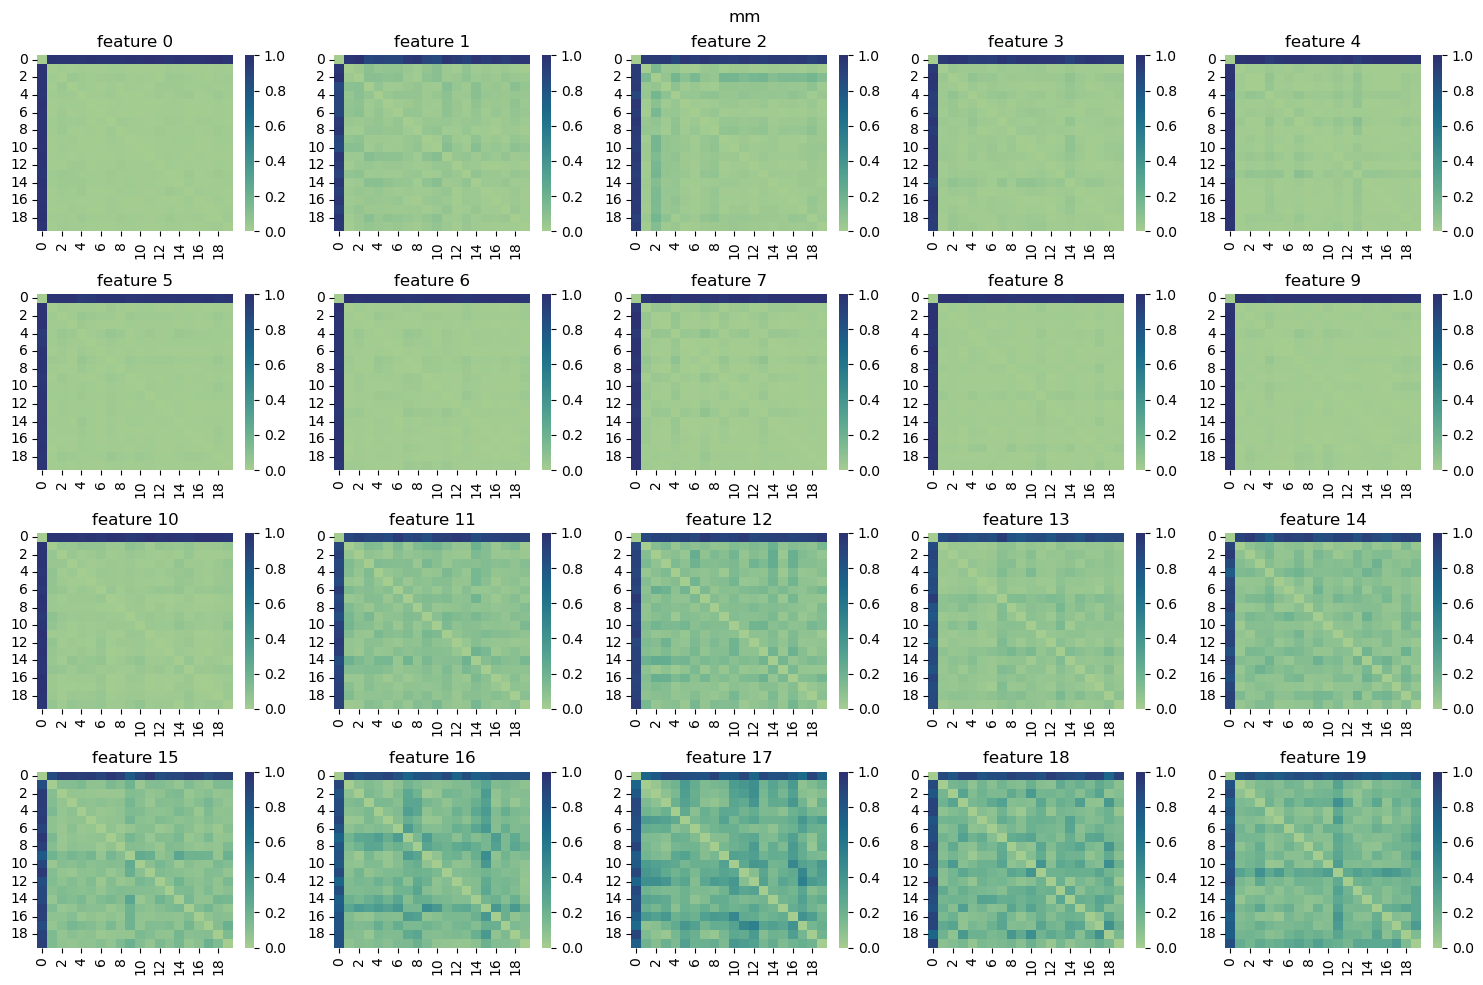

In [818]:
vis_local_model_sim(tracker2, iteration = 5, model='mm')

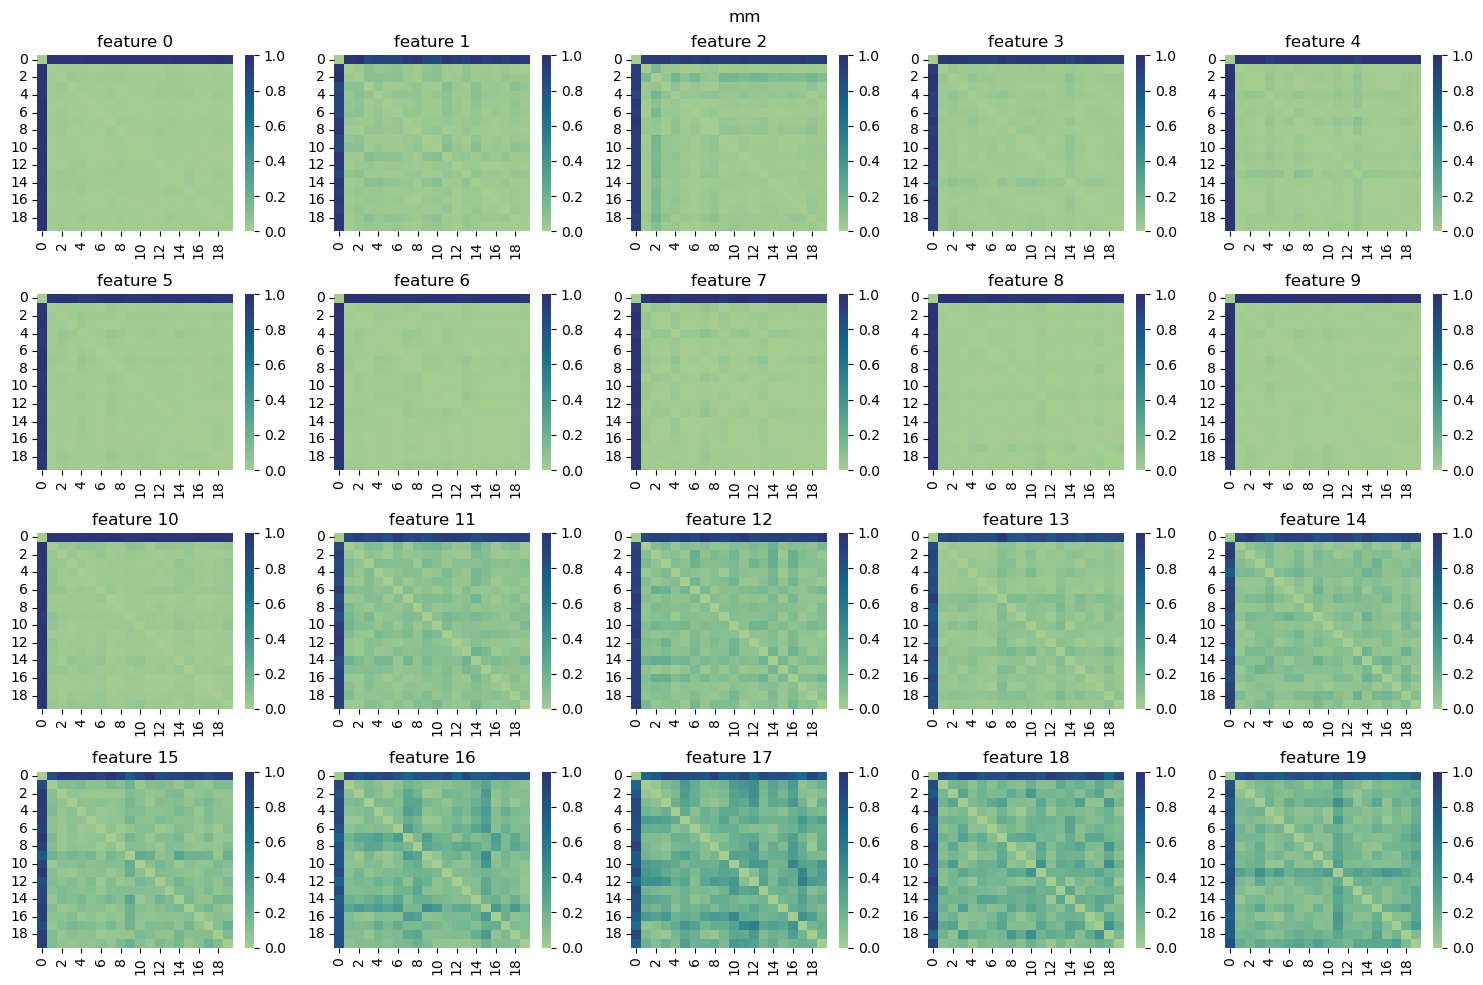

In [819]:
vis_local_model_sim(tracker2, iteration = 20, model='mm')

##### Ours

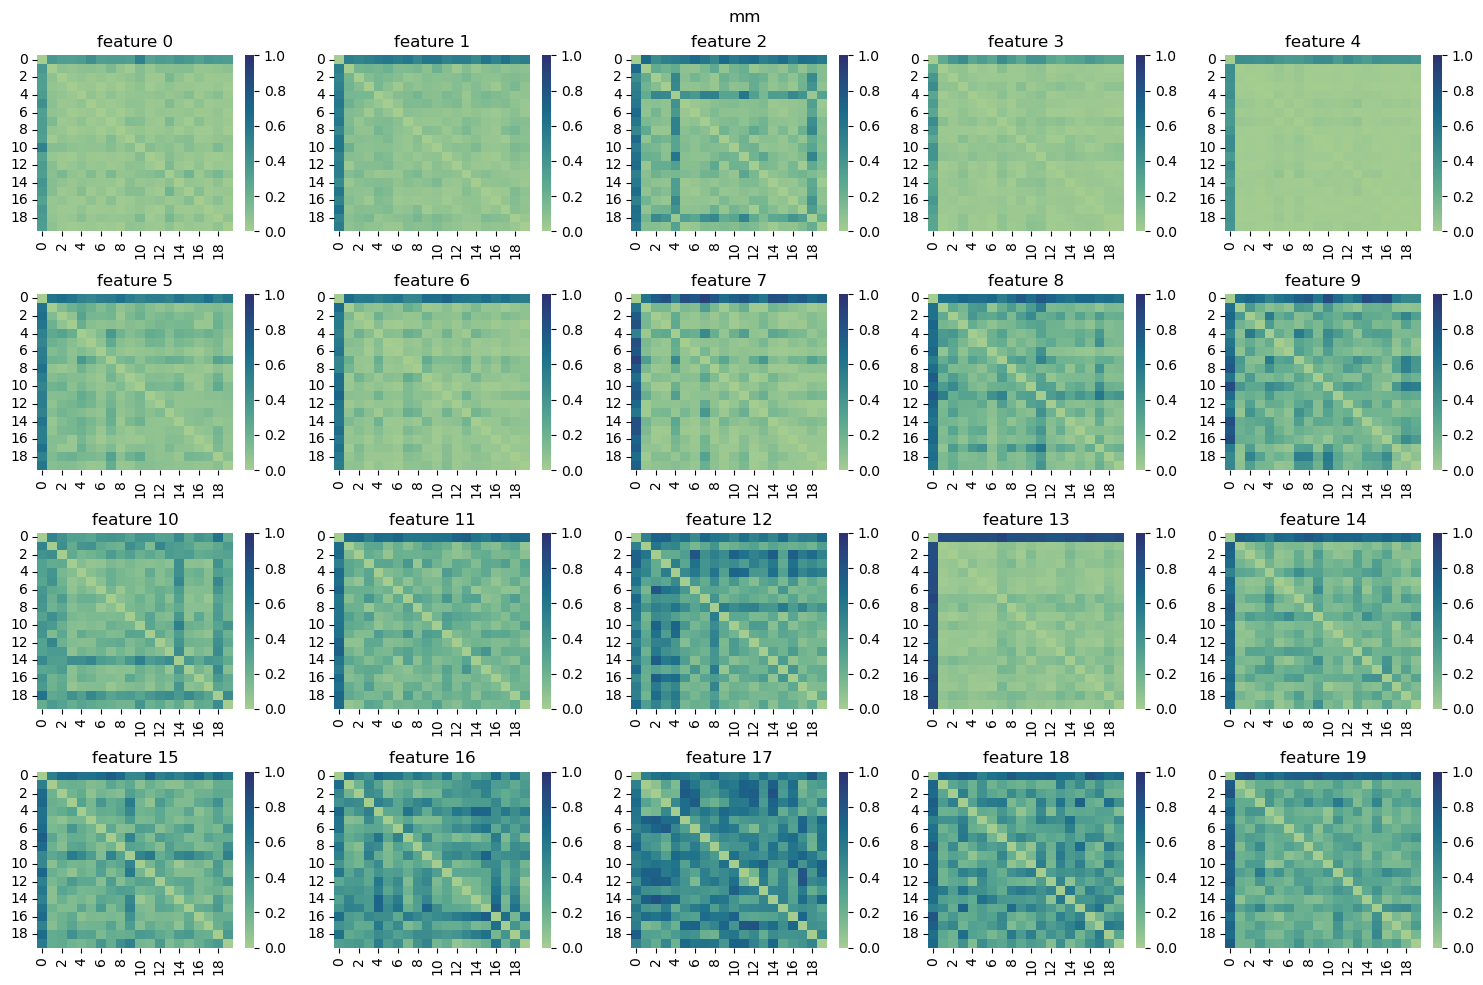

In [820]:
vis_local_model_sim(tracker3, iteration = 1, model='mm')

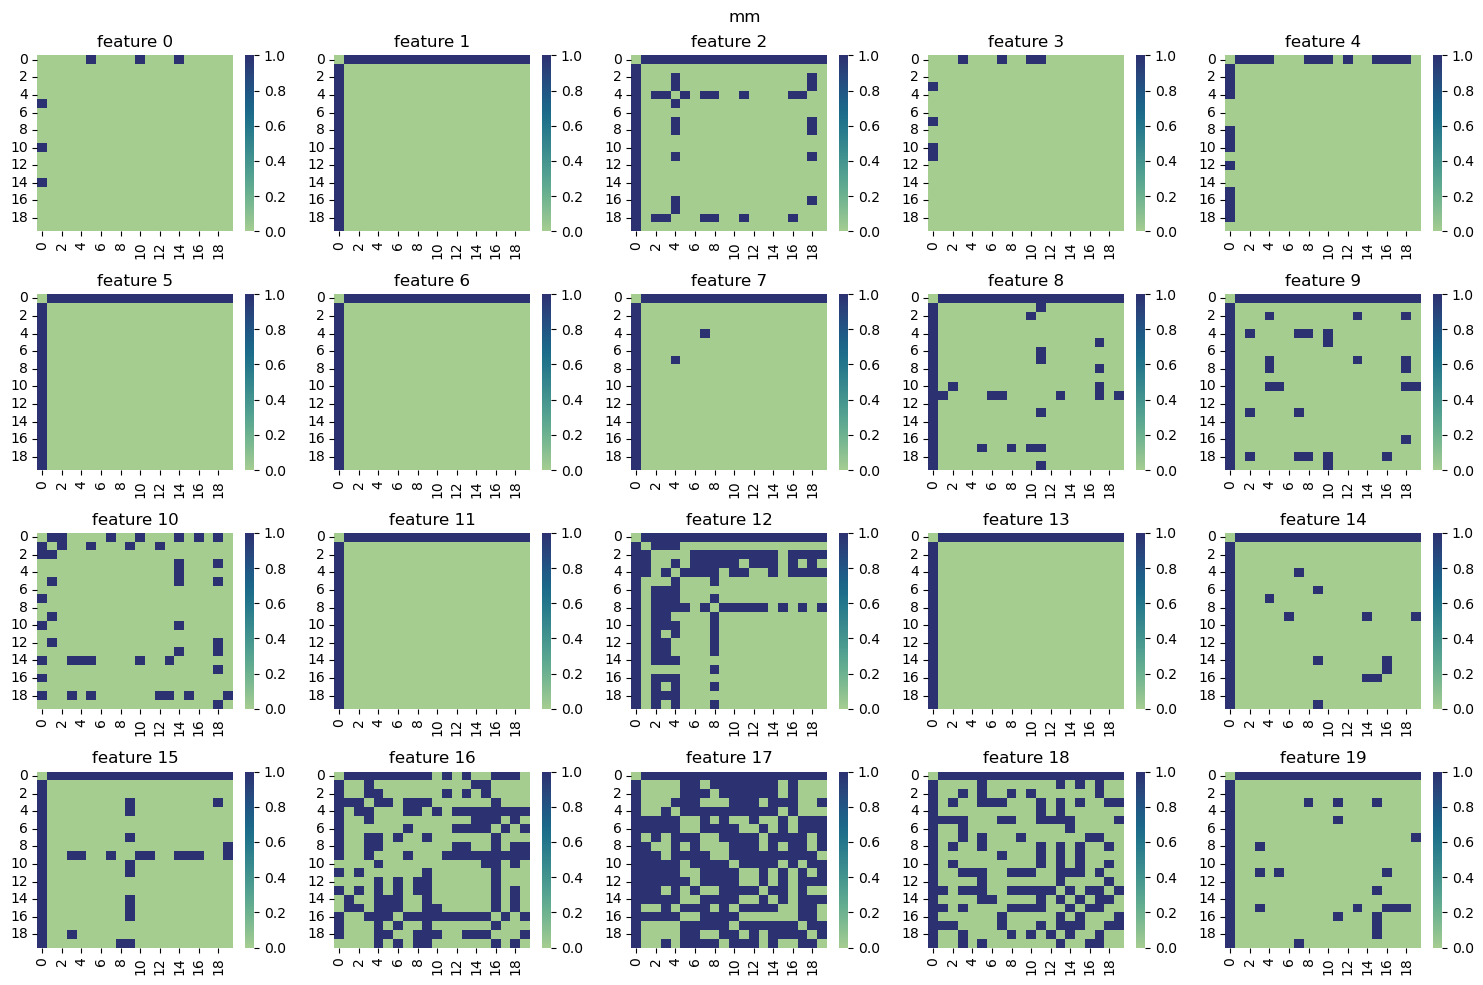

In [821]:
vis_local_model_sim_t(tracker3, iteration = 1, model='mm')

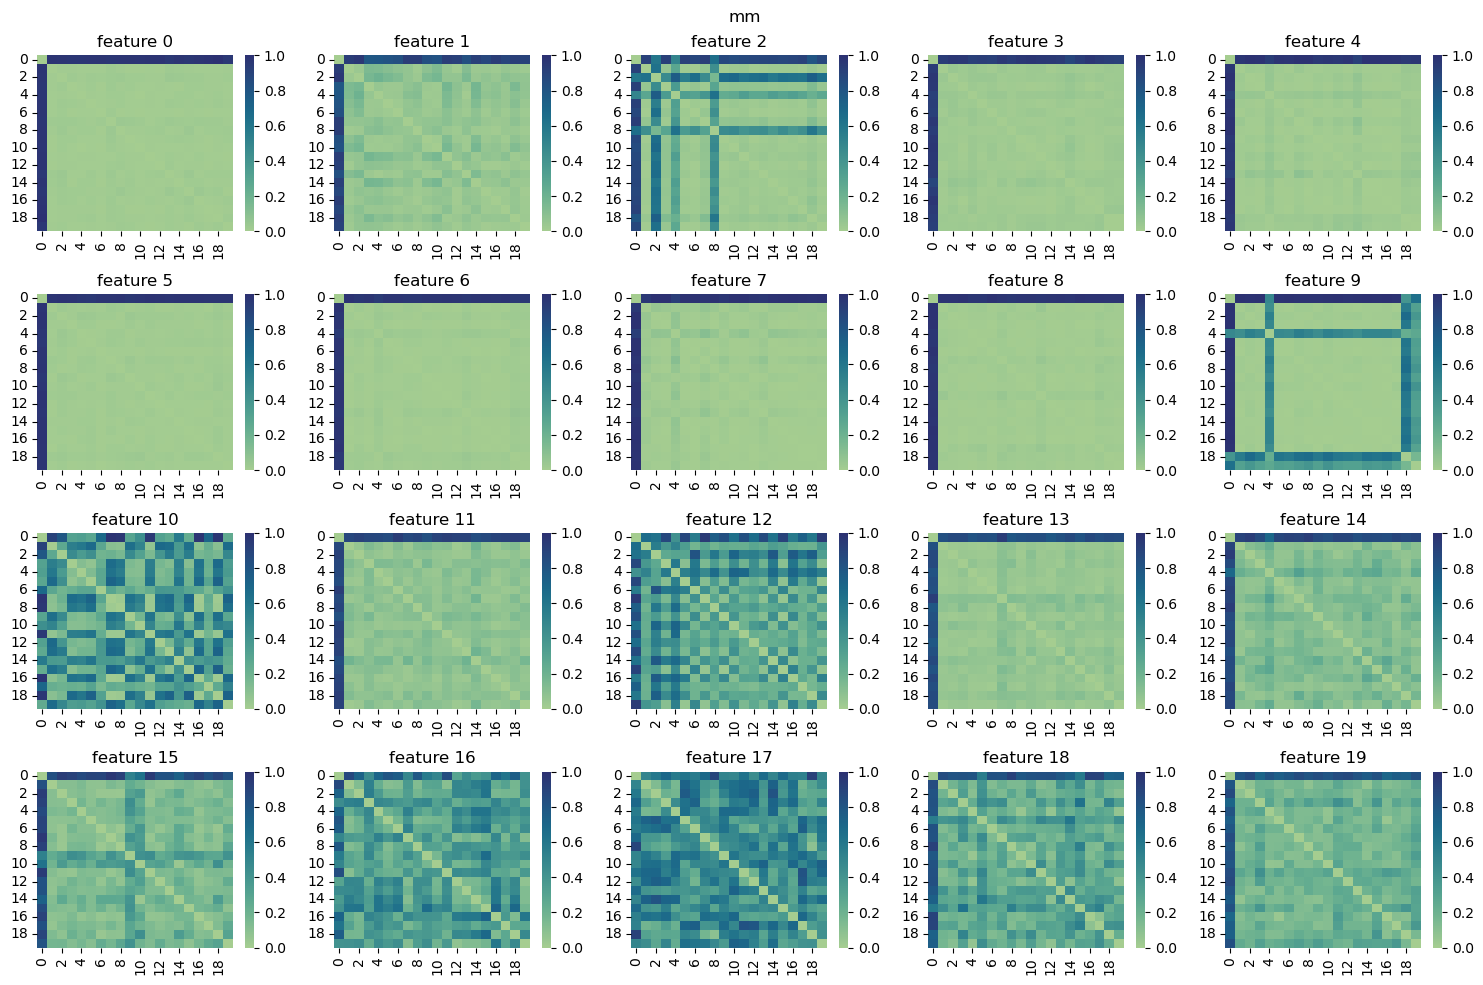

In [822]:
vis_local_model_sim(tracker3, iteration = 2, model='mm')

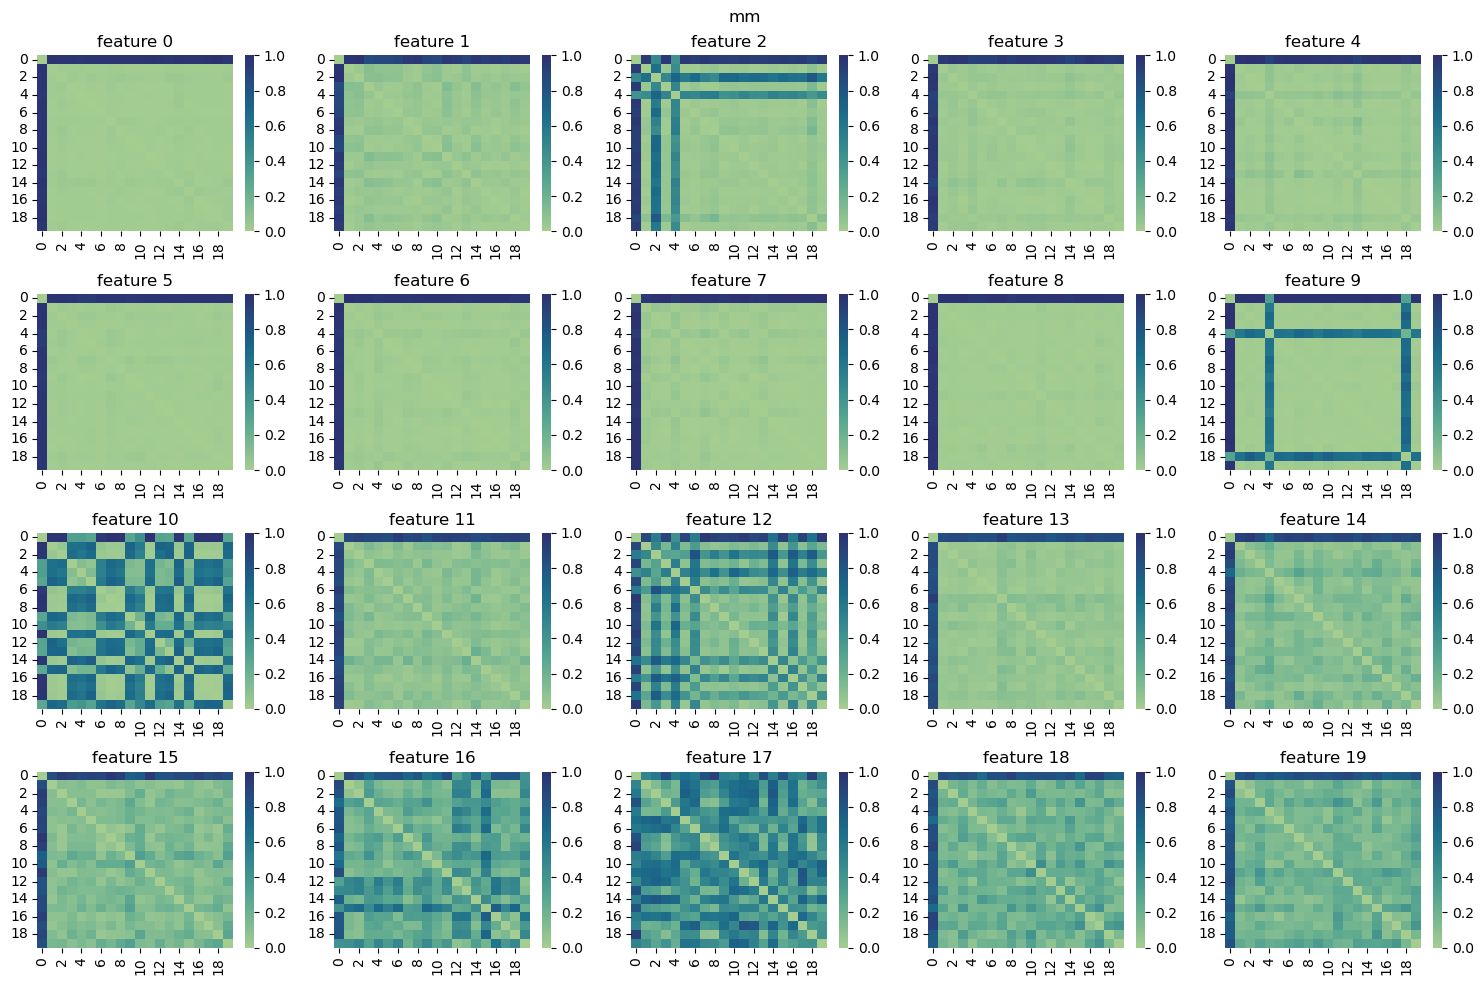

In [823]:
vis_local_model_sim(tracker3, iteration = 20, model='mm')

### MARY

In [824]:
trackery0 = trackers['mary_sigmoid_lr_local']
trackery1 = trackers['mary_sigmoid_lr_simpleavg']
trackery2 = trackers['mary_sigmoid_lr_complementary']
trackery3 = trackers['mary_sigmoid_lr_fedmechw']

#### Local

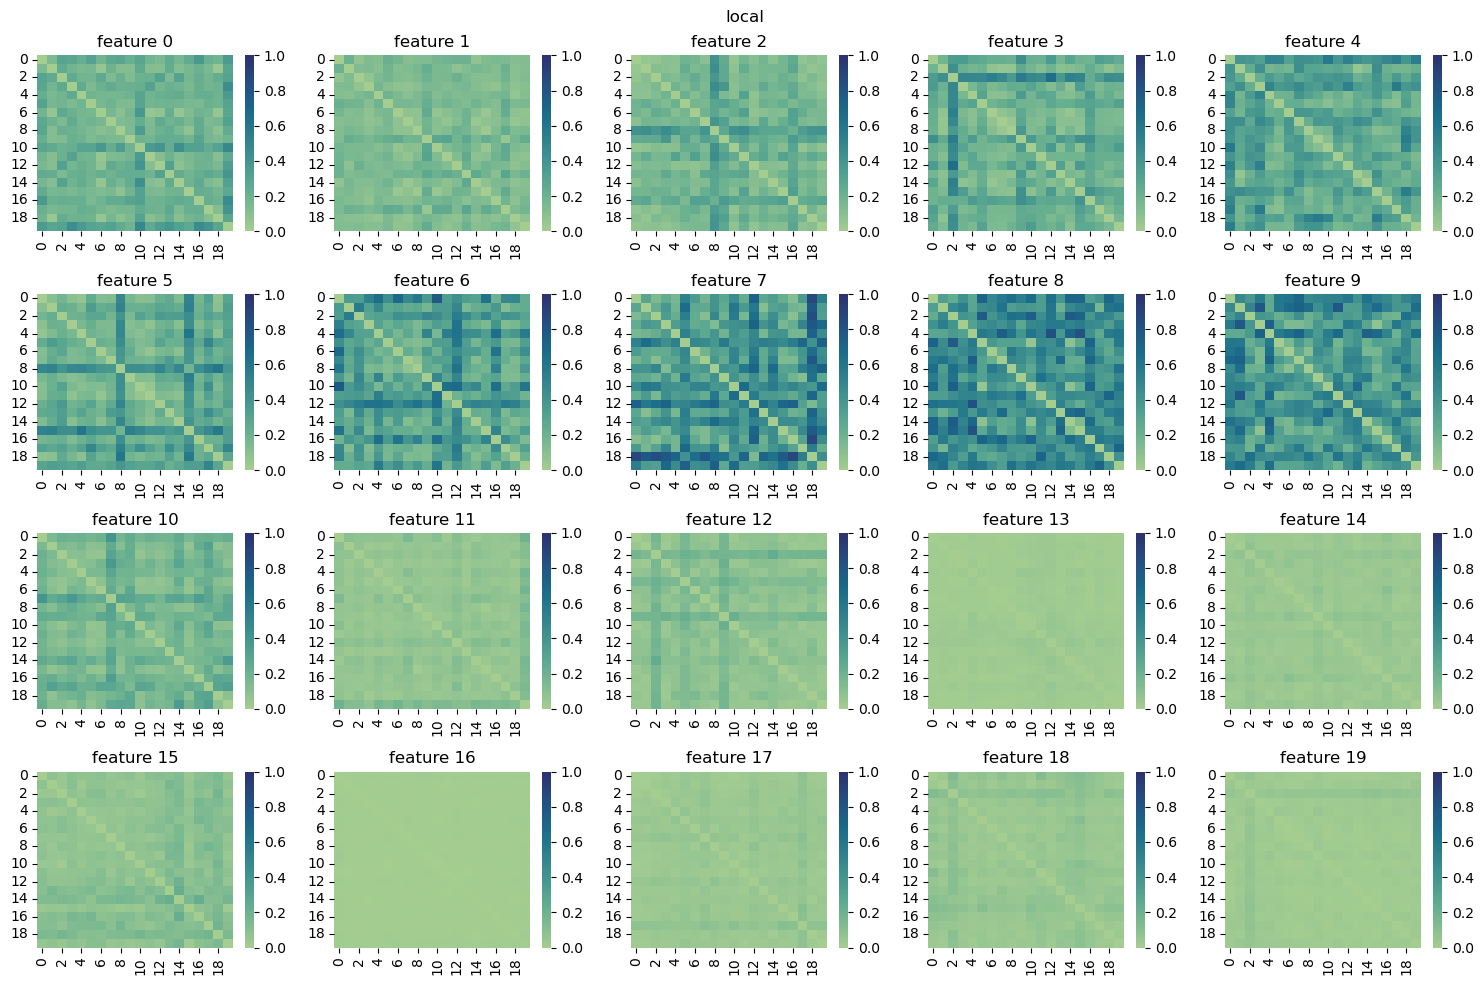

In [825]:
vis_local_model_sim(trackery0, iteration = 1, model='local')

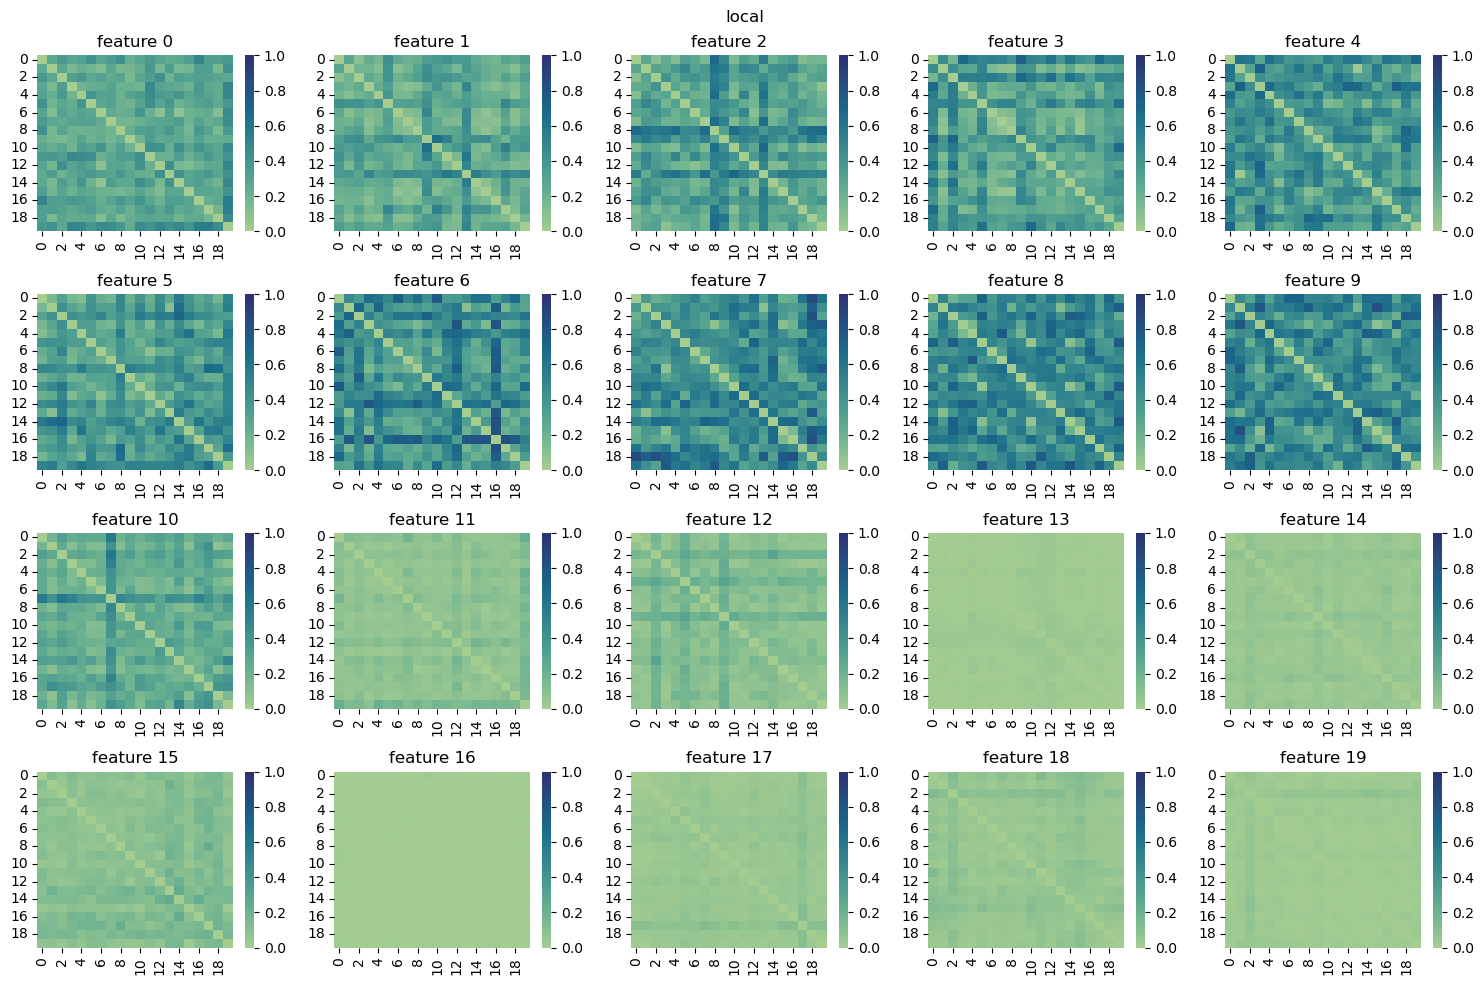

In [826]:
vis_local_model_sim(trackery0, iteration = 20, model='local')

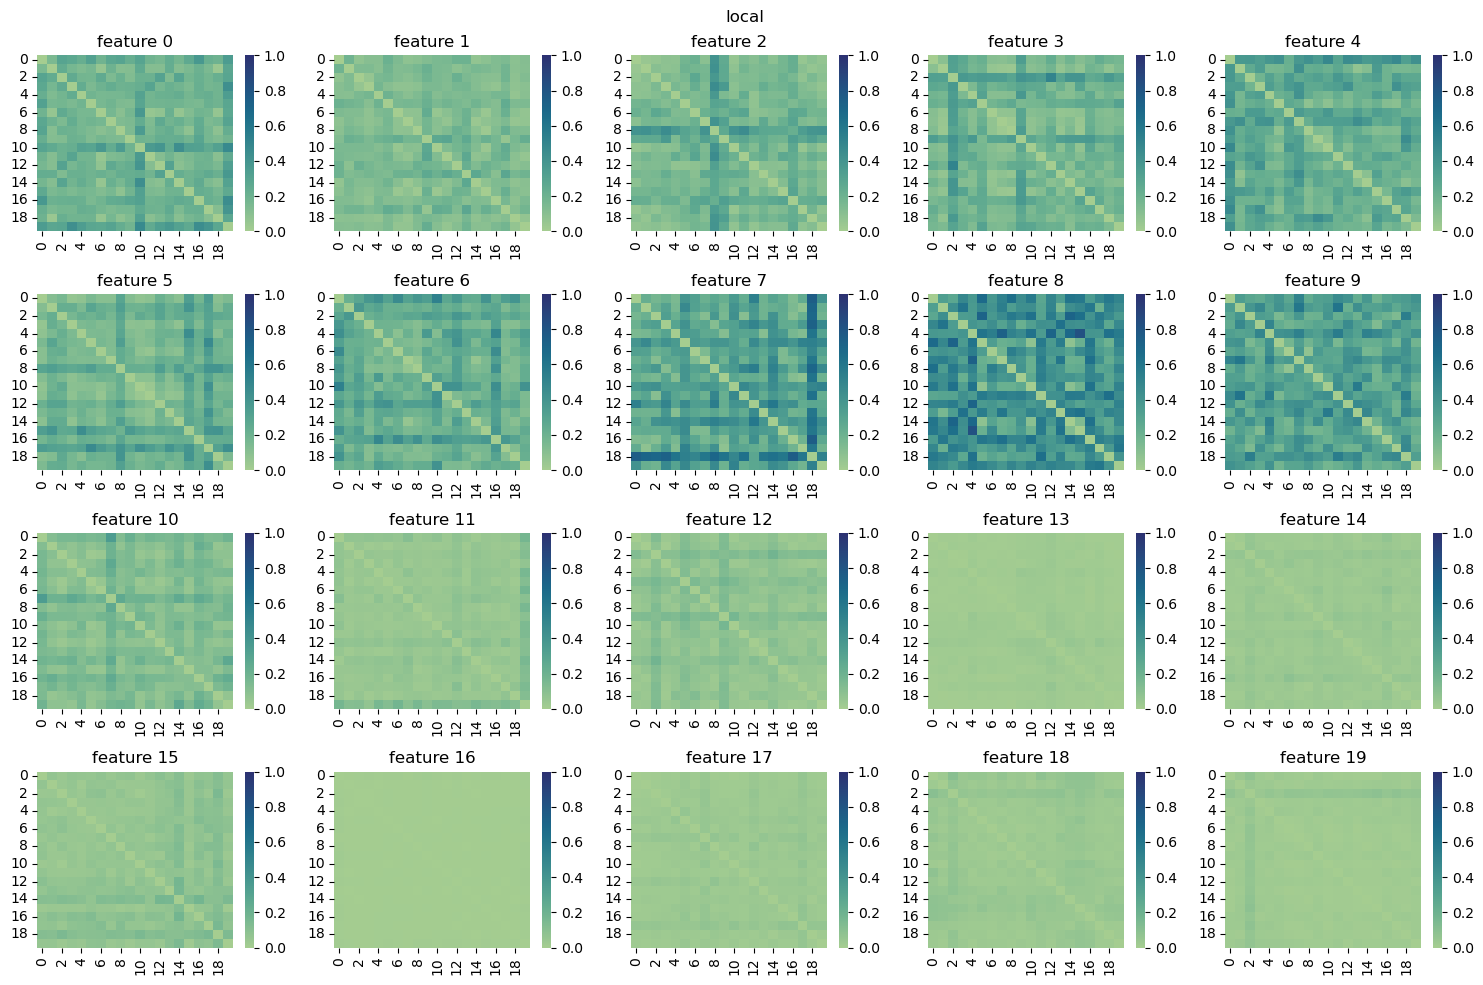

In [827]:
vis_local_model_sim(trackery1, iteration = 1, model='local')

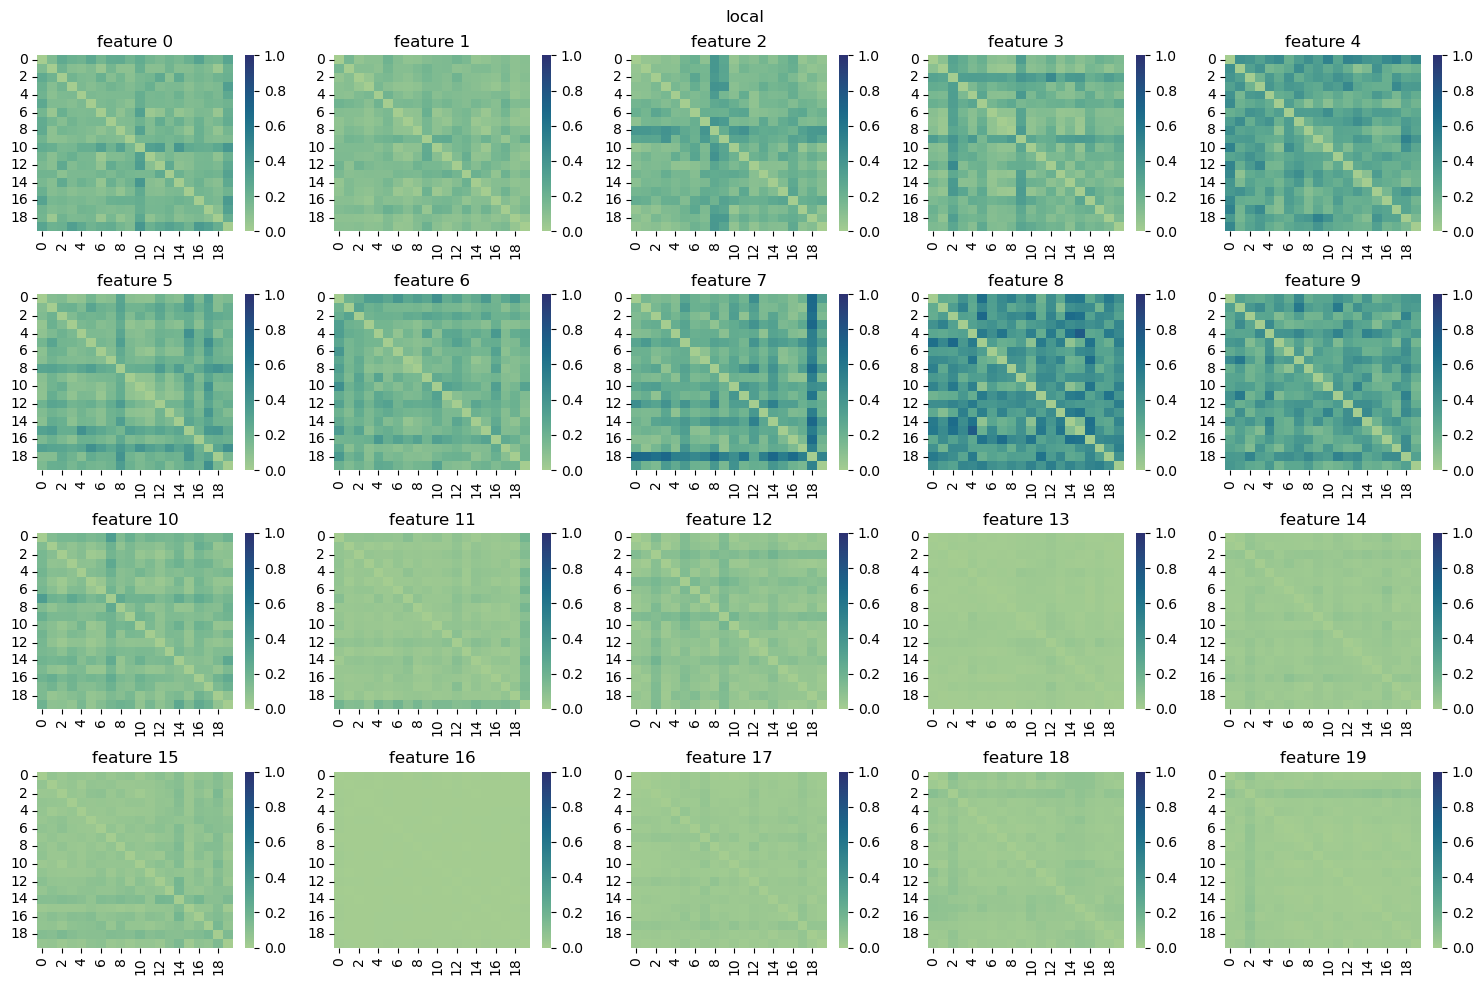

In [828]:
vis_local_model_sim(trackery1, iteration = 20, model='local')

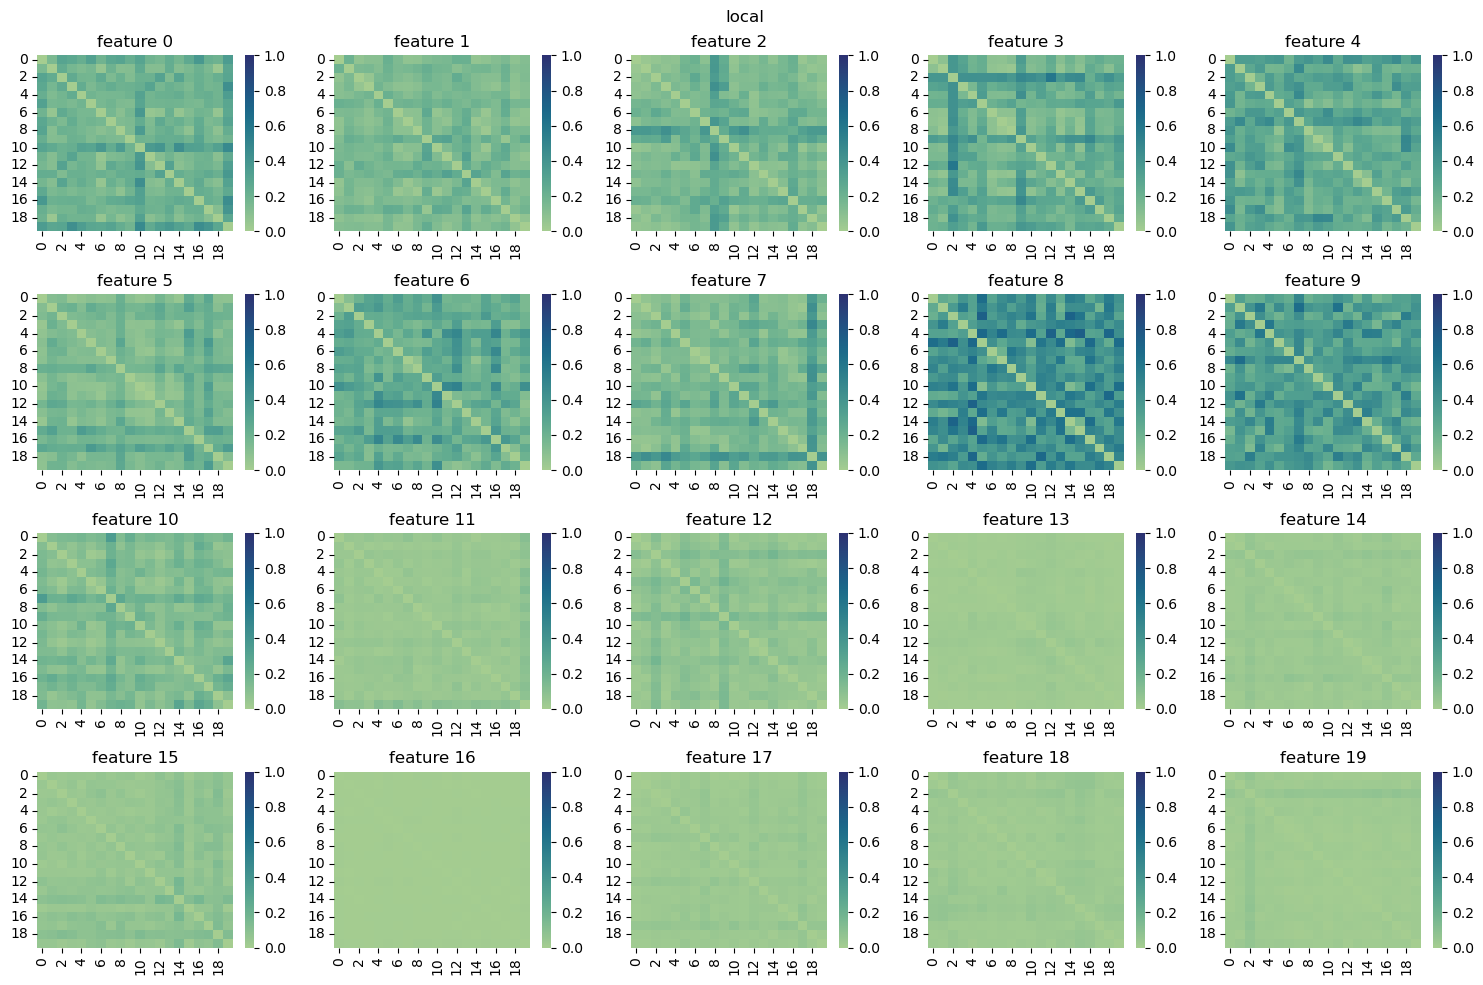

In [829]:
vis_local_model_sim(trackery2, iteration = 1, model='local')

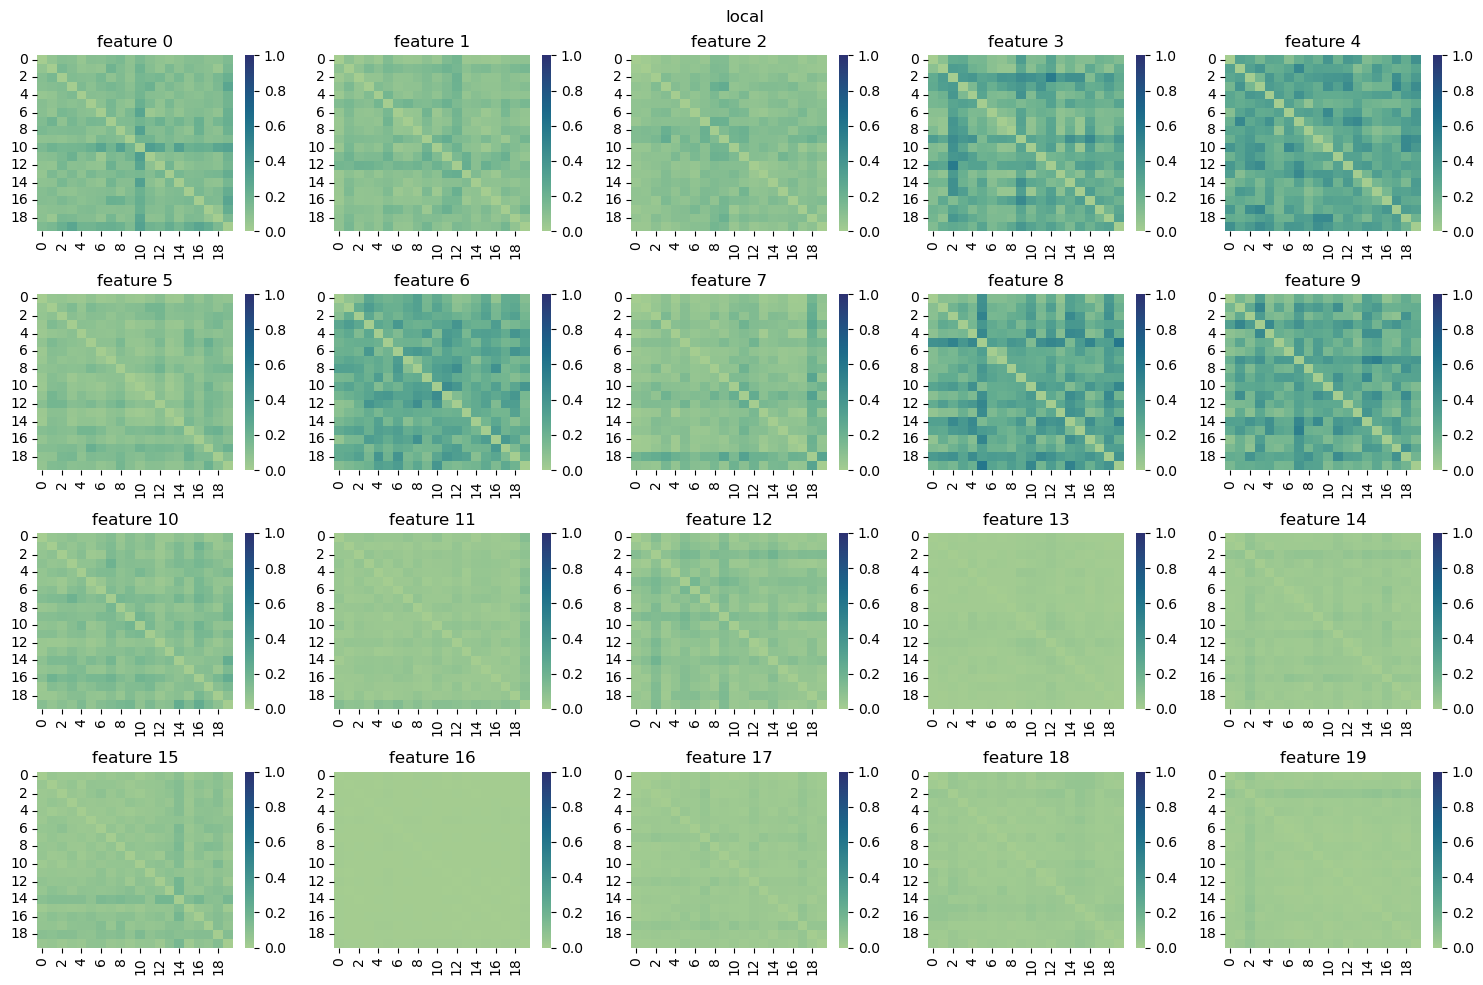

In [830]:
vis_local_model_sim(trackery2, iteration = 20, model='local')

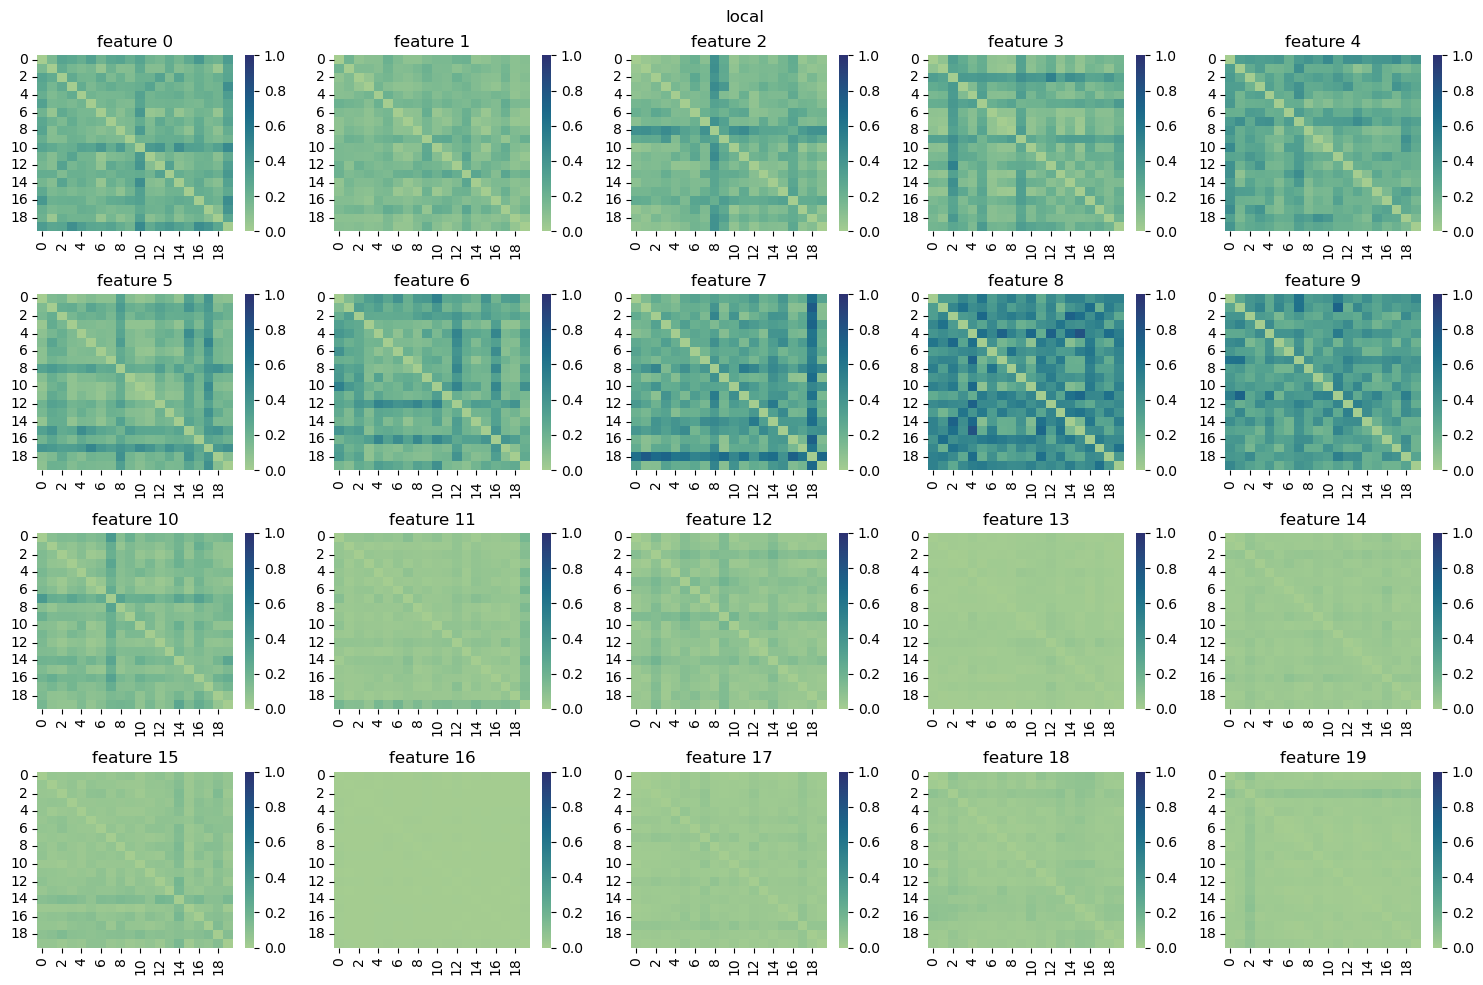

In [831]:
vis_local_model_sim(trackery3, iteration = 1, model='local')

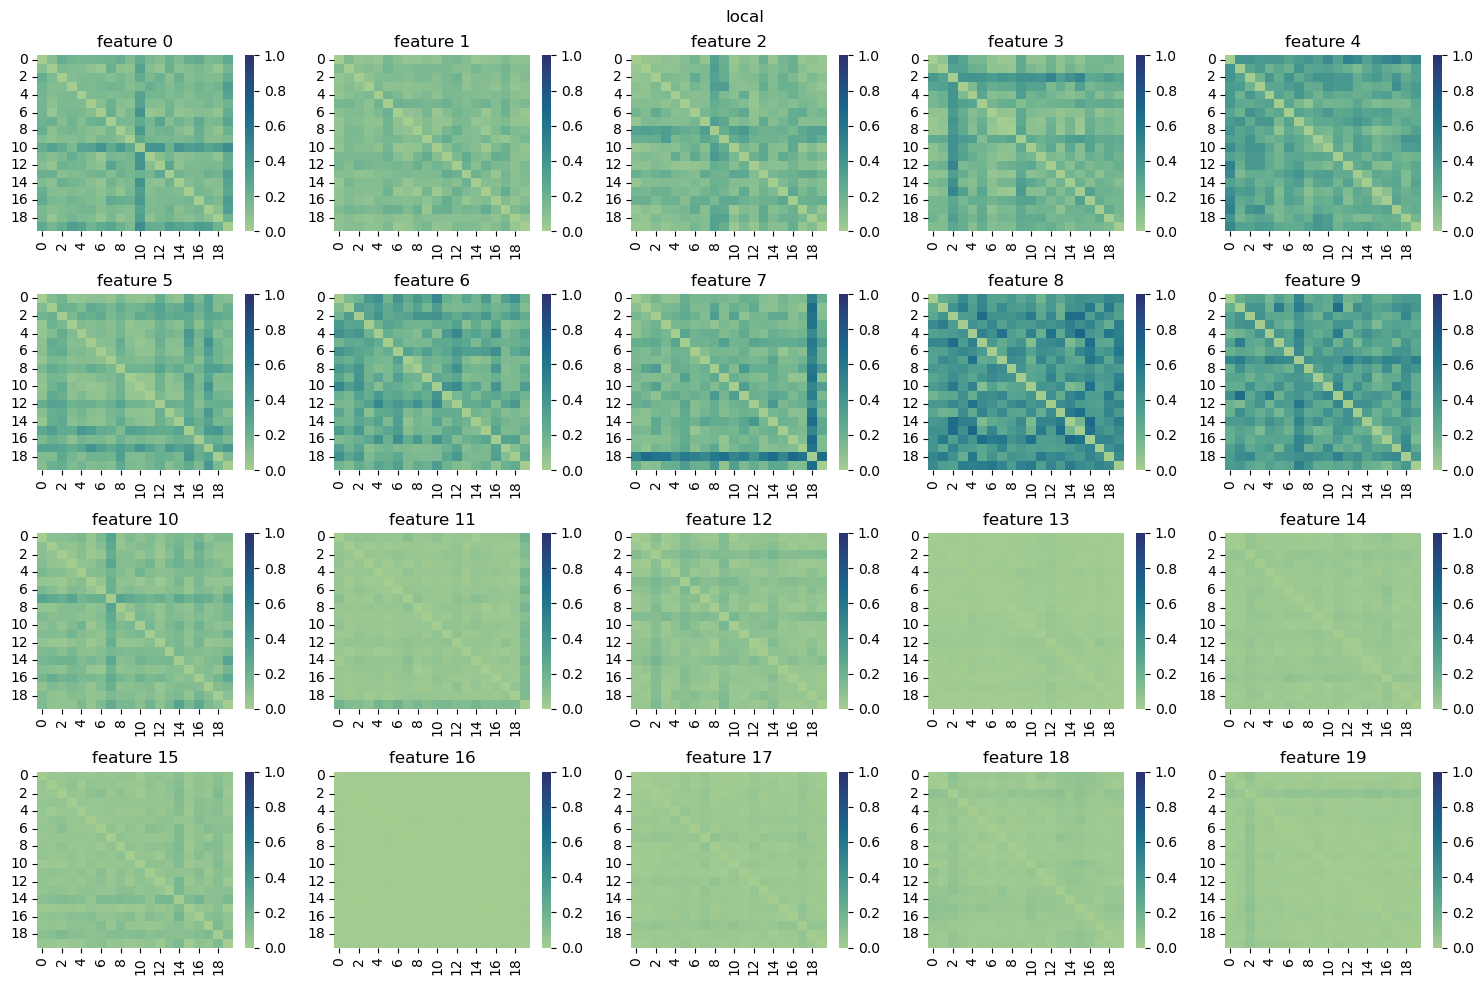

In [832]:
vis_local_model_sim(trackery3, iteration = 20, model='local')

#### Mechanism

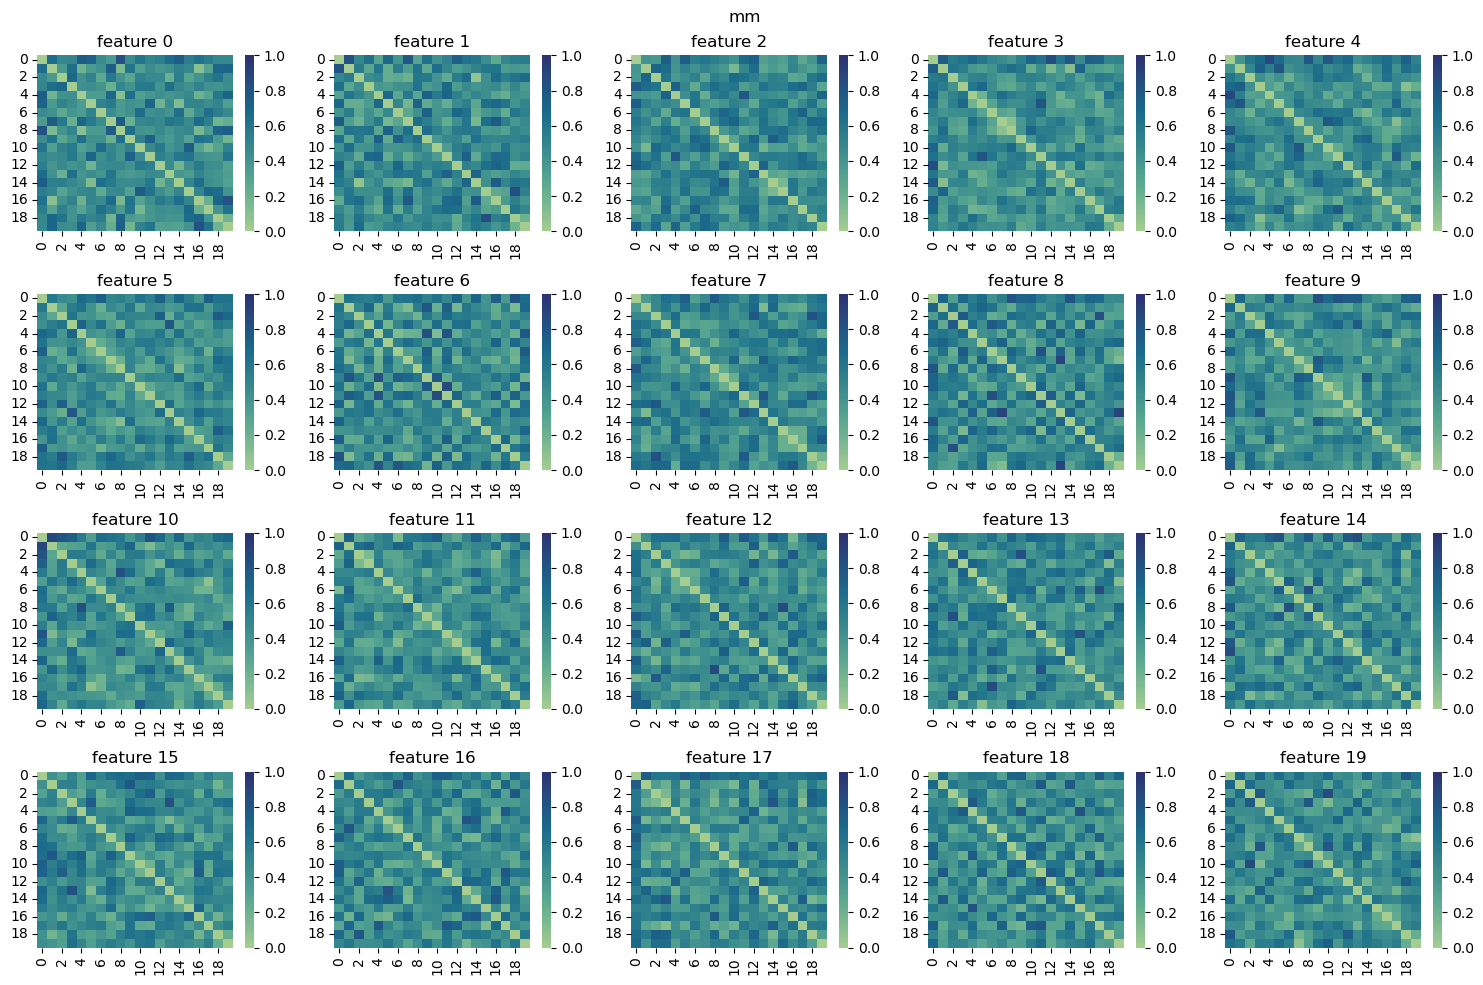

In [833]:
vis_local_model_sim(trackery1, iteration = 1, model='mm')

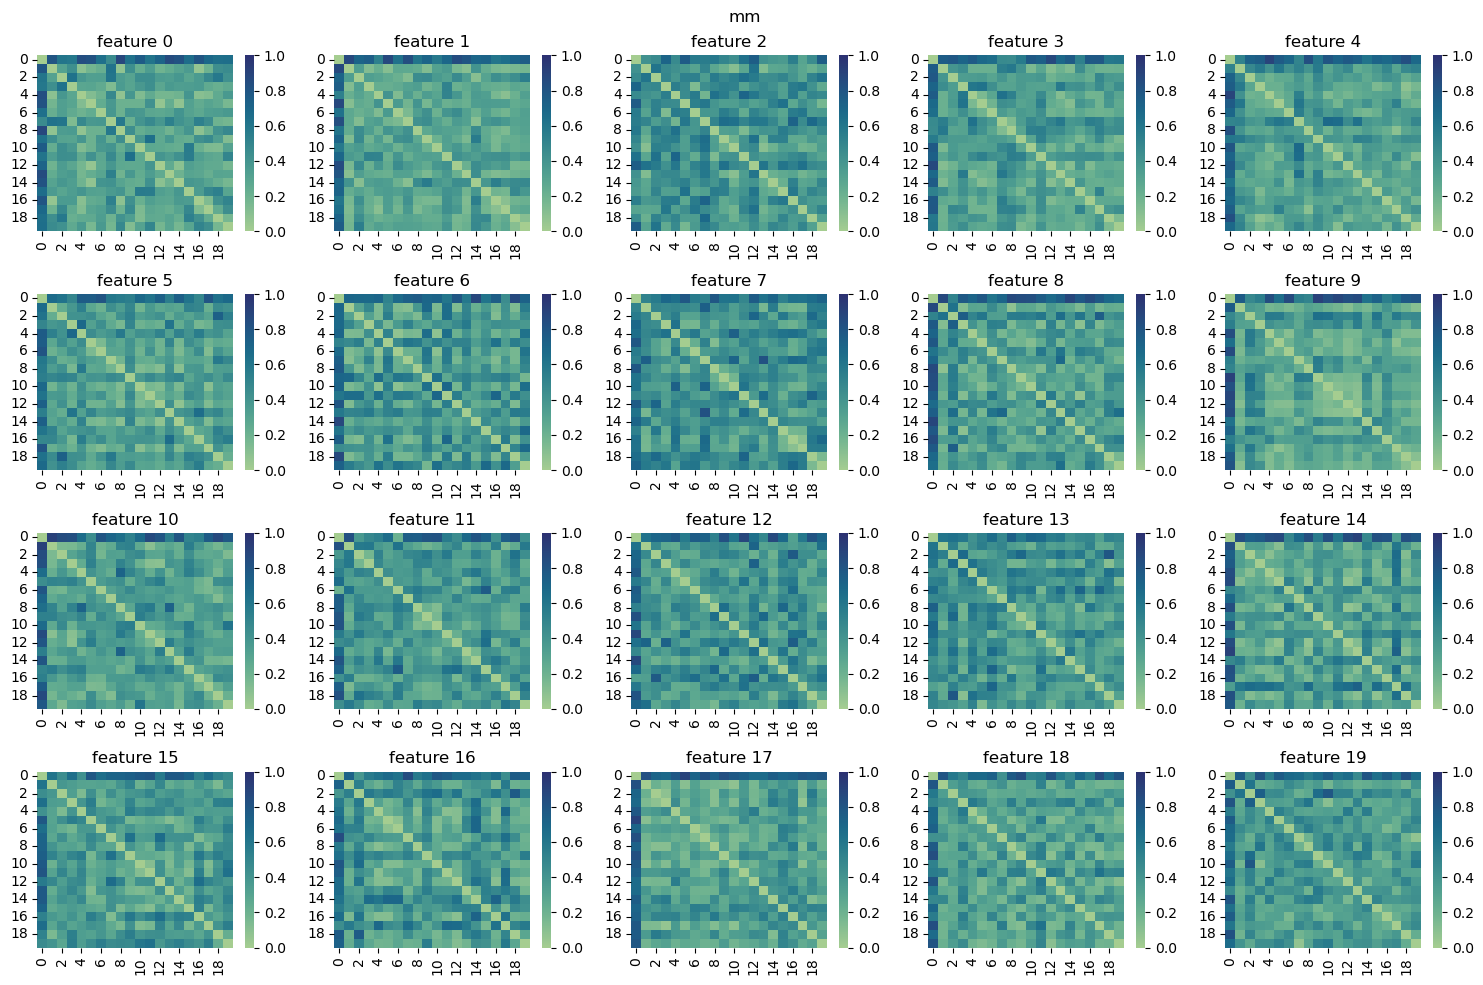

In [835]:
vis_local_model_sim(trackery2, iteration = 20, model='mm')

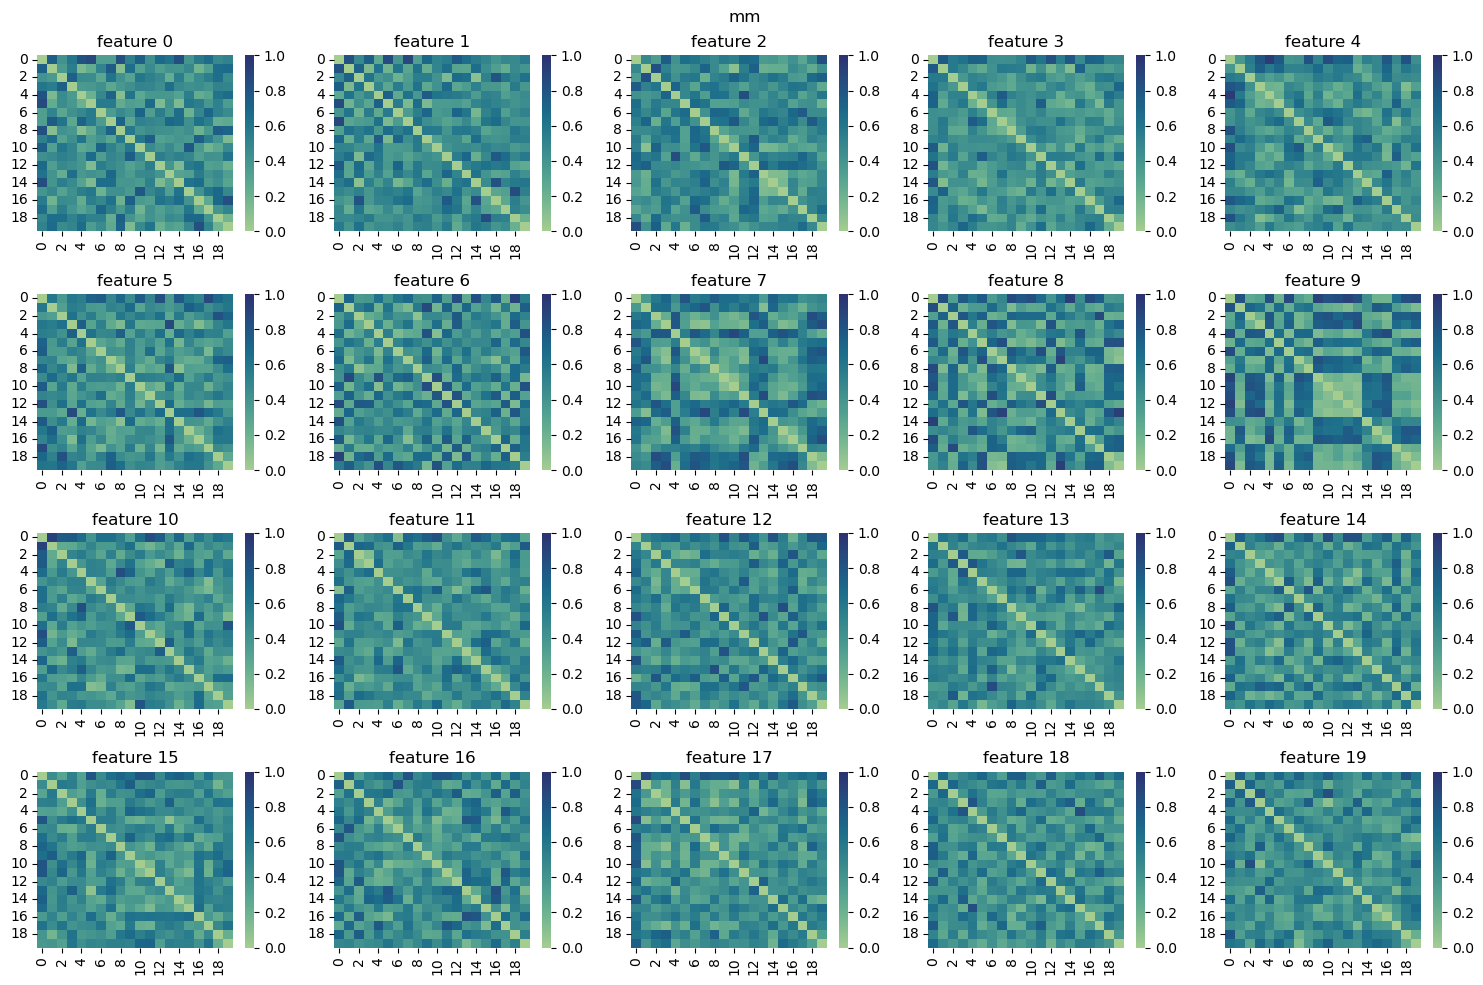

In [834]:
vis_local_model_sim(trackery3, iteration = 20, model='mm')